# Data Preparation

In [188]:
#knitr::purl(here("Rmd/childcare_article_analyses.Rmd"), here("R/childcare_article_analyses.R"))

In [189]:
library(vegan)
library(microbiome)
library(tidyverse)
library(here)
library(future)
library(furrr)
library(broom)
library(ggpubr)

In [190]:
# load data and helper functions
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/bayesian_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/mb_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/reporting.R")

In [191]:
load(here("data/data_transfer.RData"))
source(here("R/read.R"))

In [192]:
# take over the meta variables I created in other docs
meta_new <- data_transfer[, 1:9] 

In [193]:
head(meta_new)

subject_id sample_id time cc  age_d  age_d_s    bf_count bf_count_s  bf_ratio
1 207        sa_10000  post no   98.00  0.0320946 6.00      0.43948544 1       
2 388        sa_10038  post yes  98.00  0.0320946 0.00     -1.65710371 0       
3 381        sa_10118  post yes 108.00  0.5275689 6.59      0.64565004 1       
4 283        sa_10211  post yes 107.03  0.4795079 5.00      0.09005391 1       
5 216        sa_10230  post no  100.00  0.1311895 7.00      0.78891696 1       
6 277        sa_10247  pre  yes  79.00 -0.9093066 6.10      0.47442859 1

In [194]:
# create catories for bf and childcare and specifically for ccyes vs rest
meta_new <- meta_new %>%
  mutate(
      groups = ifelse(time == "pre" & cc == "no", "noCCpre", ifelse(
          time == "pre" & cc == "yes", "CCpre", ifelse(
              time == "post" & cc == "no", "noCCpost", "CCpost"))),
      bf = ifelse(bf_ratio <= 0.25, "lowBF", ifelse(
          bf_ratio <0.75, "mediumBF", "highBF")),
      ccpost = ifelse(groups == "CCpost", 1, 0)) %>% 
  mutate(
      groups = as.factor(groups), 
      bf = as.factor(bf), 
      ccpost = as.factor(ccpost))

In [195]:
# add confounding variables
confounders <- foreign::read.spss(here("data/meta_data/bibo_confounders.sav"), to.data.frame = T) %>%
    select(ID, SIBLINGS, childsex) %>% rename(sibling = SIBLINGS, subject_id = ID) %>%
    mutate(sibling = ifelse(sibling == "at leat 1 sibling", 1, ifelse(sibling == "firstborn", 0, 1))) %>%
    filter(subject_id %in% meta_new$subject_id)
meta_new <- meta_new %>% left_join(confounders, by = "subject_id")

Warning message in foreign::read.spss(here("data/meta_data/bibo_confounders.sav"), :
“Undeclared level(s) 2 added in variable: SIBLINGS”Warning message in foreign::read.spss(here("data/meta_data/bibo_confounders.sav"), :
“Undeclared level(s) 6, 999 added in variable: DELIVERYmode”

In [196]:
# create new pseq object (read.R results in the object "genus" Leo created)
otu <- otu_to_df(genus, transpose = FALSE)
otu <- otu %>% 
    select(species, meta_new$sample_id) %>% 
    df_to_otu()
pseq <- phyloseq(otu, df_to_sd(meta_new), tax_table(genus))
# add diversity indeces to sample data
diversities <- 
    global(pseq, index = "all") %>% 
    select(contains("diversities")) %>% 
    rownames_to_column("sample_id")
colnames(diversities) <- gsub("diversities_", "", colnames(diversities))

sample_data(pseq) <- 
    sd_to_df(pseq) %>% 
    left_join(diversities, by = "sample_id") %>%
    df_to_sd()
meta <- sd_to_df(pseq)
# clr and relative abundance transformation to deal with compositionality of mb data
pseq.clr <- microbiome::transform(pseq, transform = "clr")
pseq.rel <- microbiome::transform(pseq, "compositional")

Richness
Observed (richness 0)
Diversity
Evenness
Dominance
Rarity
Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

# PCA

A PCA using CLR transformed values displays the Aitchison distance.

In [197]:
otus.clr <- otu_to_df(pseq.clr)
colnames(otus.clr)[which(colnames(otus.clr) == "Clostridium \\(sensu stricto\\)")] <- "Clostridium_sensu_stricto"
colnames(otus.clr) <- c("sample_id", gsub("_", "", colnames(otus.clr)[-1]))
colnames(otus.clr) <- gsub("\\.", "", colnames(otus.clr))
colnames(otus.clr) <- gsub(" ", "", colnames(otus.clr))
genus <- colnames(otus.clr)[-1]
data <- sd_to_df(pseq.clr) %>%
    left_join(otus.clr, by = "sample_id")
data$sibling <- as.factor(data$sibling)
data$childsex <- as.factor(data$childsex)


# PCA with CLR values (euclidean distance of clr transformed values = Aitchison distance) 
pcx <- prcomp(otus.clr %>% column_to_rownames("sample_id"))
# extract loadings
pcx_rot <- 
    pcx$rotation %>%
        as.tibble() %>%
        mutate_all(function(x) x*10) %>%
        add_column(genus = rownames(pcx$rotation))

# add PCs to data
princomps <- pcx$x %>% as.data.frame() %>%
    rownames_to_column("sample_id") %>%
    select(PC1, PC2, PC3, PC4, PC5, sample_id)
data <- data %>% left_join(princomps, by = "sample_id") 
                   
# how much variance do pcs explain?
pc1 <- round(pcx$sdev[1]^2/sum(pcx$sdev^2),2)
pc2 <- round(pcx$sdev[2]^2/sum(pcx$sdev^2),2)
pc3 <- round(pcx$sdev[3]^2/sum(pcx$sdev^2),2)
pc4 <- round(pcx$sdev[4]^2/sum(pcx$sdev^2),2)
pc5 <- round(pcx$sdev[5]^2/sum(pcx$sdev^2),2)                   

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

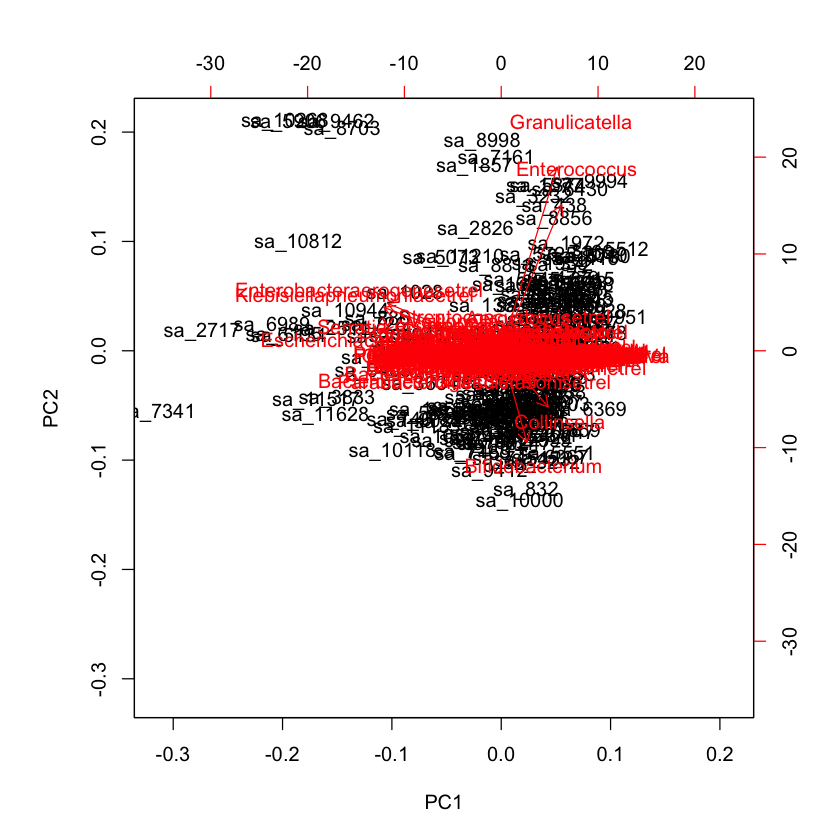

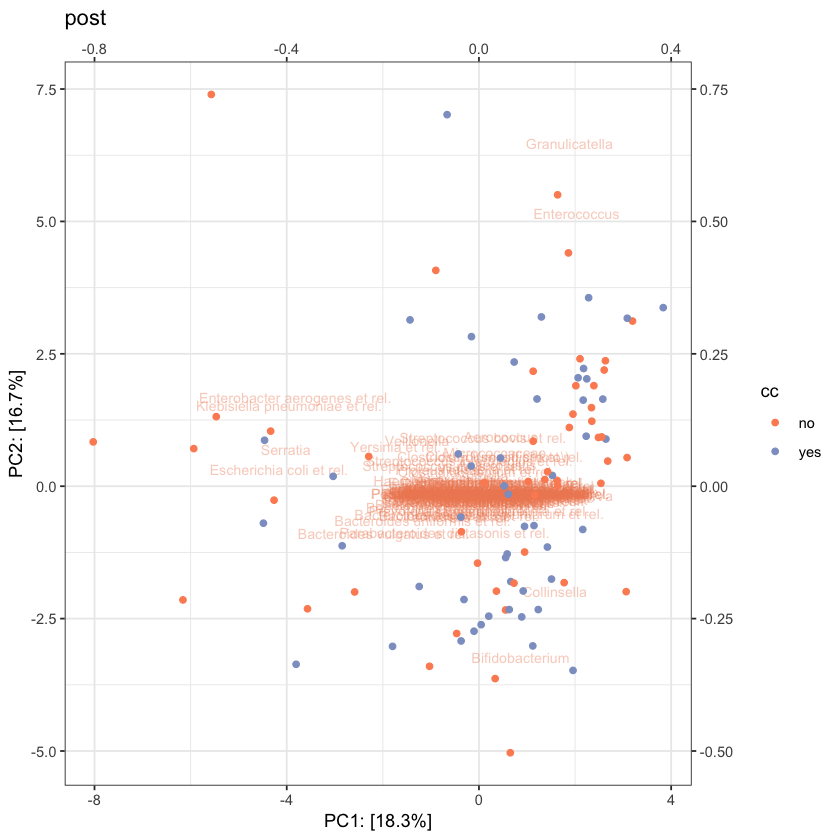

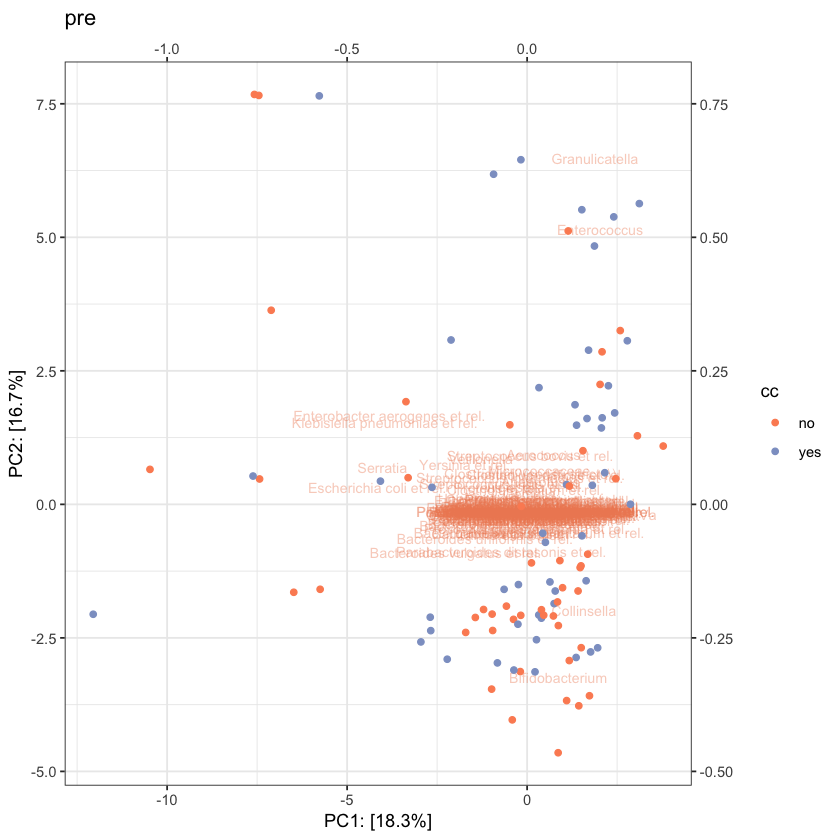

[[1]]

[[2]]

[[3]]

[[4]]


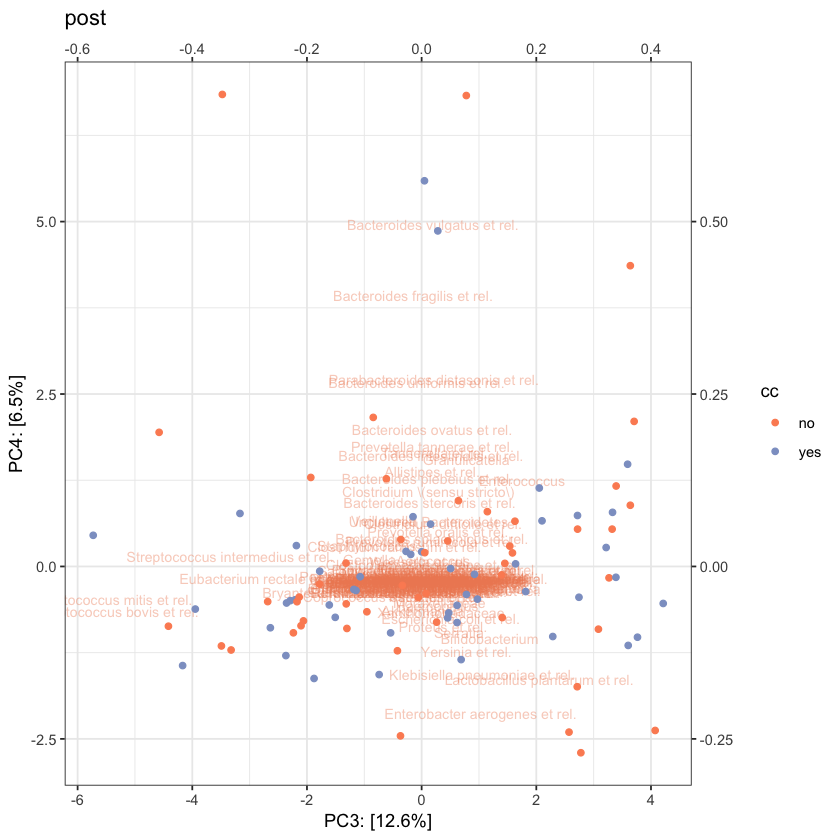

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

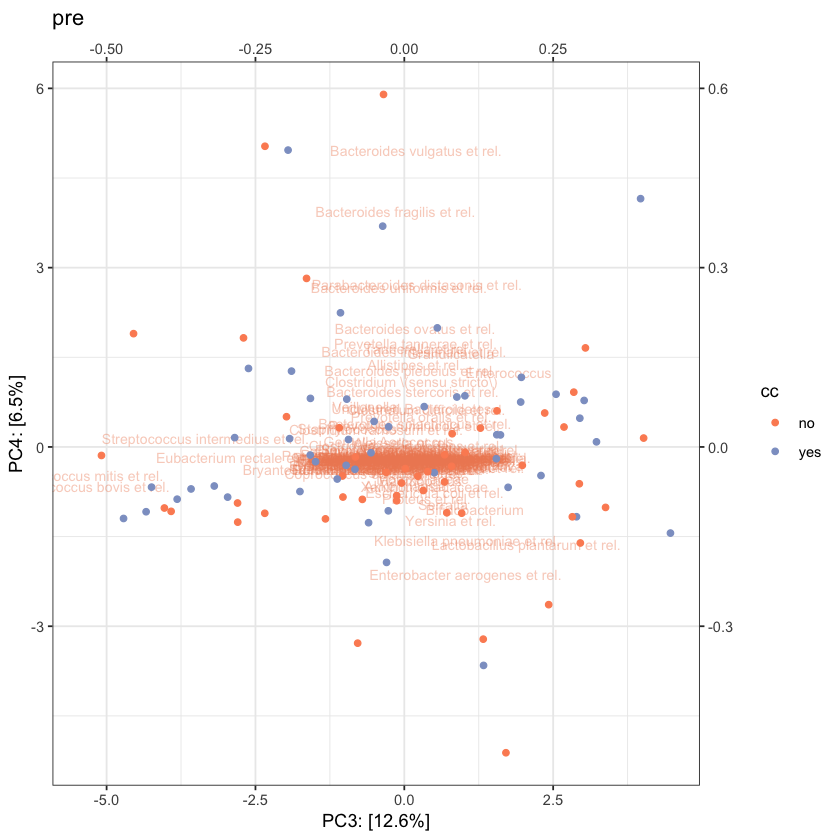

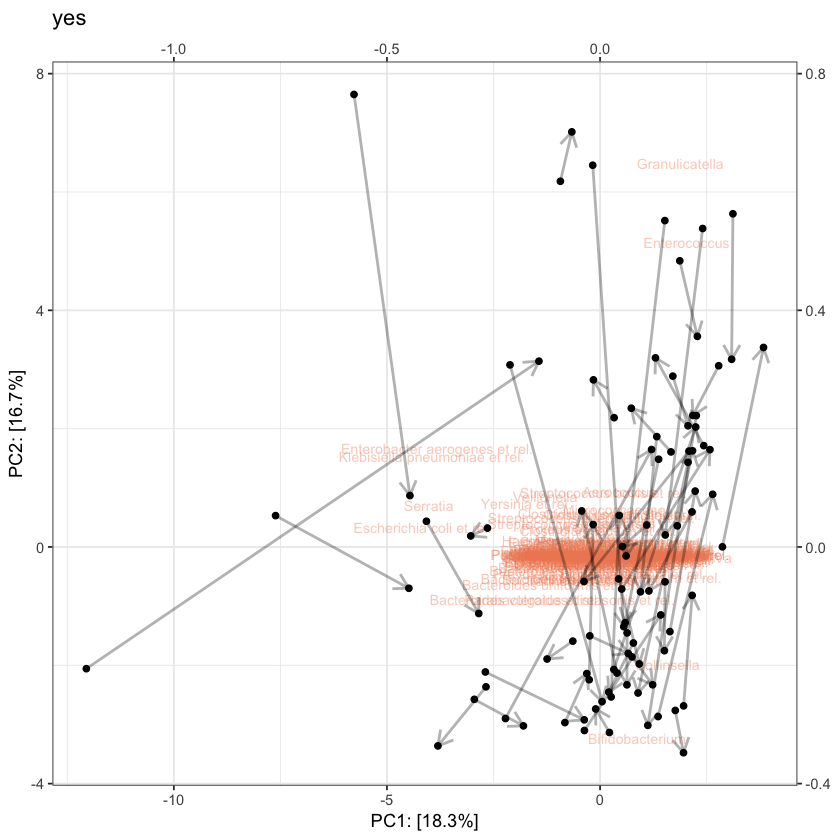

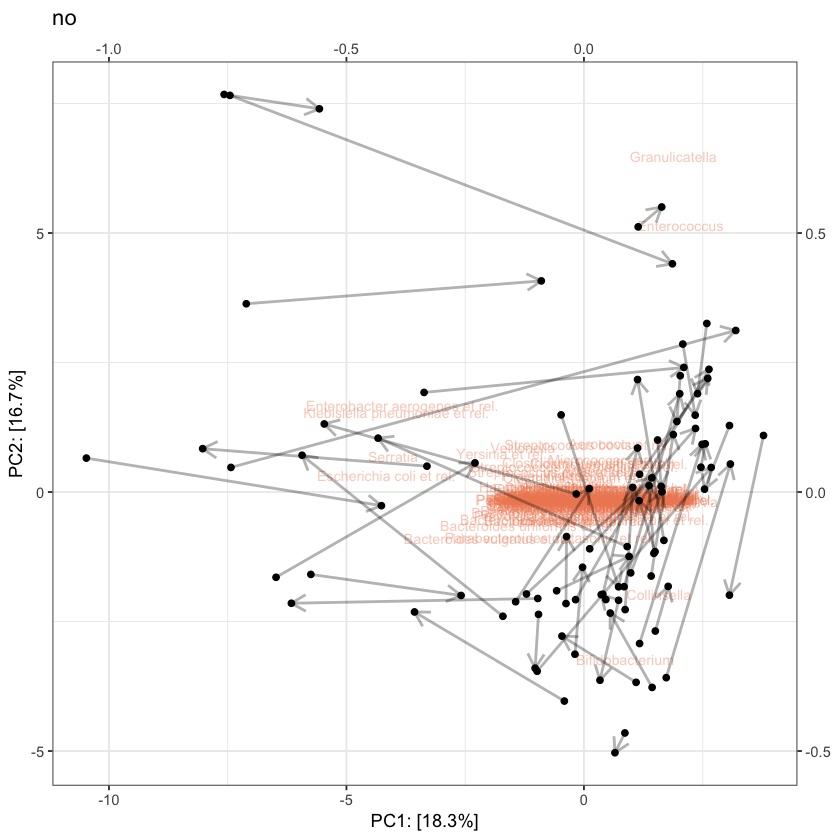

[[1]]

[[2]]

[[3]]

[[4]]


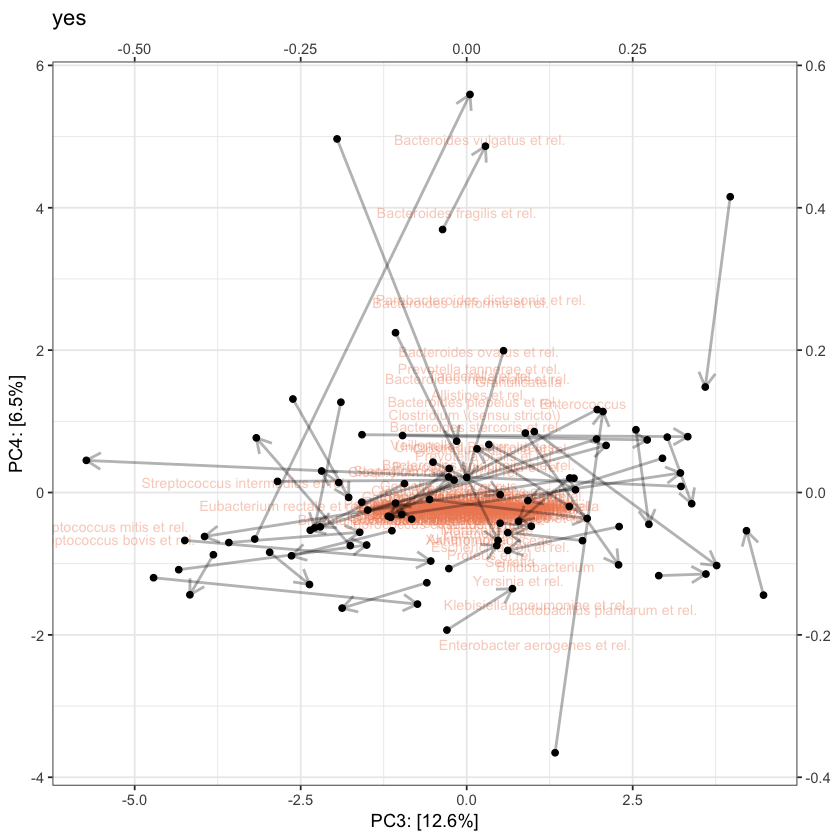

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

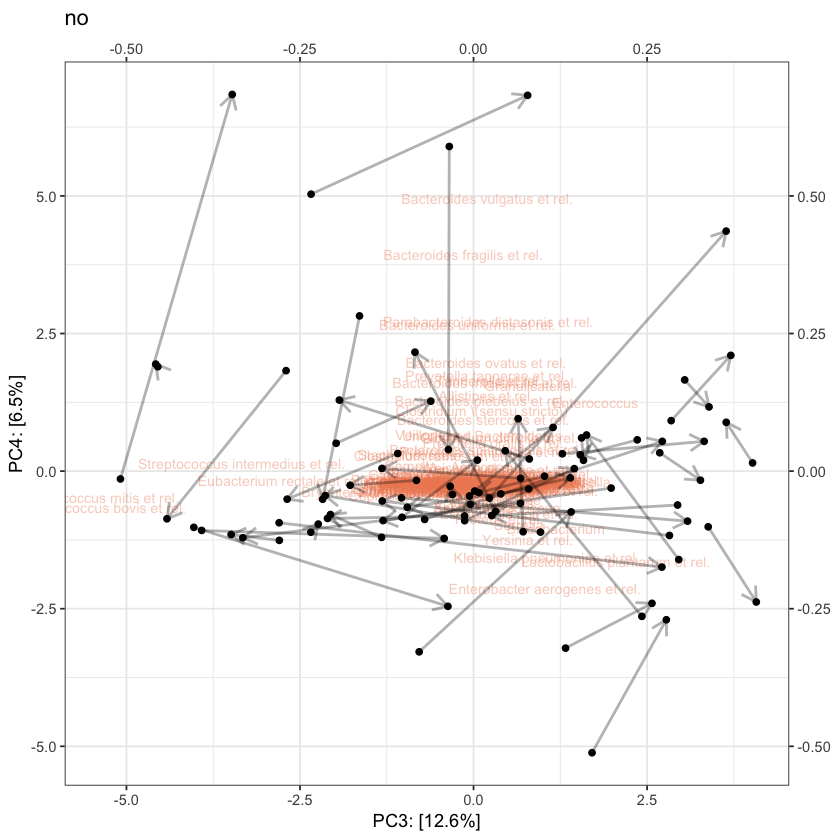

In [198]:
p_versions <- c(1:4)
# just to compare with others:
stats::biplot(pcx)
# biplots
biplot_cc <- biplot(pseq.clr, color = "cc", split_by = "time")
biplot_cc
map2(biplot_cc, p_versions, ~ggsave(plot = .x, filename = here(glue("fig/aitchison_pca_cc_{.y}.png"))))


biplot_time <- biplot(pseq.clr, split_by = "cc", connect_series = "time")
biplot_time
map2(biplot_time, p_versions, ~ggsave(plot = .x, filename = here(glue("fig/aitchison_pca_time_{.y}.png"))))



# Multiple Impuation

In [199]:
# I recode the contrasts so that I have the comparisons I want:
# the intercept will reflect our group we want to compare to others (cc post)
# the cc coefficient then compares to no cc post, the time coefficent 
# to cc pre and the interaction to no cc pre
# contrasts(data$cc)[1, 1] <- 1
# contrasts(data$cc)[2, 1] <- 0
# contrasts(data$time)[1, 1] <- 1
# contrasts(data$time)[2, 1] <- 0

library(mice)
# Next I impute data using predictive mean matching (PMM). PMM is
# less difficult to specify. I use the PCs to impute instead of all 
# genus abundances since these are correlated
data_imp <- data %>% 
    select(
        -everything(), 
        subject_id, 
        age_d_s, 
        time, 
        cc, 
        bf_count_s, 
        sibling,
        PC1,
        PC2,
        PC3,
        PC4,
        PC5) %>%
    mice(m = 10, method = "pmm", print = F, seed = 412) %>%
    mice::complete("all")
# This I use to join genus abundances again
deselect_col <- colnames(data_imp[[1]])
data_lj <- data %>% select(-deselect_col, subject_id, time)
data_imp <- map(data_imp, ~.x %>% left_join(data_lj, by = c("subject_id", "time")))

# PERMANOVA
I cannot use Bray Curtis distance for CLR transformed data. Thus I do it once with relative abundance and for clr transformed data I use Euclidean distance, which then is the Aitchison distance. I

In [200]:
# clr/euclidean
#meta.clr <- sd_to_df(pseq.clr) %>% select(-sibling) %>% na.omit()
#otus.clr <- otu_to_df(pseq.clr, transpose = F) %>% 
#    column_to_rownames("species") %>%
#    select(meta.clr$sample_id) %>%
#    t() 

# Homogeneity assumption (for sibling I use one of the imputed sets)
dist <- vegdist(otus.clr[, -1], method = "euclidean")
hg_cc <- anova(betadisper(dist, data_imp[[1]]$cc))
hg_time <- anova(betadisper(dist, data_imp[[1]]$time))
hg_groups <- anova(betadisper(dist, data_imp[[1]]$groups))
hg_childsex <- anova(betadisper(dist, data_imp[[1]]$childsex))
hg_sibling <- anova(betadisper(dist, data_imp[[1]]$sibling))
hg_groups

Df  Sum Sq     Mean Sq  F value  Pr(>F)   
Groups      3   20.81327 6.937756 1.194218 0.3132095
Residuals 192 1115.41524 5.809454       NA        NA

In [201]:
fit_pm <- function(data_imp) {
    otus <- data_imp %>% 
        select(genus, sample_id) %>% 
        column_to_rownames("sample_id")
    meta <- data_imp %>% 
        select(-everything(), subject_id, sample_id, time, cc, age_d_s, bf_count_s, sibling, childsex) %>% 
        column_to_rownames("sample_id")
    pm <- adonis(
        otus ~ time * cc + age_d_s + bf_count_s, 
        method = "euclidean", 
        data =  meta)
    list(aov = pm$aov.tab, coefs = coefficients(pm))
}
plan(multiprocess)
pms <- future_map(data_imp, fit_pm)

In [202]:
map(pms, ~.x$aov %>% as.data.frame())

$`1`
            Df  SumsOfSqs   MeanSqs  F.Model          R2 Pr(>F)
time         1   58.44385  58.44385 1.469109 0.007321524  0.137
cc           1   52.63601  52.63601 1.323117 0.006593950  0.181
age_d_s      1   79.55309  79.55309 1.999734 0.009965973  0.037
bf_count_s   1  197.05992 197.05992 4.953515 0.024686582  0.001
time:cc      1   36.22884  36.22884 0.910688 0.004538550  0.486
Residuals  190 7558.54904  39.78184       NA 0.946893421     NA
Total      195 7982.47075        NA       NA 1.000000000     NA

$`2`
            Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time         1   58.44385  58.44385 1.4715483 0.007321524  0.132
cc           1   52.63601  52.63601 1.3253136 0.006593950  0.188
age_d_s      1   79.55309  79.55309 2.0030543 0.009965973  0.036
bf_count_s   1  208.02110 208.02110 5.2377298 0.026059739  0.001
time:cc      1   37.79750  37.79750 0.9516972 0.004735063  0.472
Residuals  190 7546.01920  39.71589        NA 0.945323752     NA
Total      195 7982.47075        NA        NA 1.000000000     NA

$`3`
            Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time         1   58.44385  58.44385 1.4719626 0.007321524  0.119
cc           1   52.63601  52.63601 1.3256867 0.006593950  0.195
age_d_s      1   79.55309  79.55309 2.0036183 0.009965973  0.024
bf_count_s   1  209.94537 209.94537 5.2876689 0.026300801  0.001
time:cc      1   37.99714  37.99714 0.9569932 0.004760072  0.434
Residuals  190 7543.89530  39.70471        NA 0.945057680     NA
Total      195 7982.47075        NA        NA 1.000000000     NA

$`4`
            Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time         1   58.44385  58.44385 1.4730744 0.007321524  0.110
cc           1   52.63601  52.63601 1.3266881 0.006593950  0.192
age_d_s      1   79.55309  79.55309 2.0051316 0.009965973  0.035
bf_count_s   1  215.91188 215.91188 5.4420483 0.027048252  0.001
time:cc      1   37.72438  37.72438 0.9508411 0.004725902  0.457
Residuals  190 7538.20155  39.67474        NA 0.944344399     NA
Total      195 7982.47075        NA        NA 1.000000000     NA

$`5`
            Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time         1   58.44385  58.44385 1.4739710 0.007321524  0.112
cc           1   52.63601  52.63601 1.3274955 0.006593950  0.161
age_d_s      1   79.55309  79.55309 2.0063520 0.009965973  0.021
bf_count_s   1  219.97860 219.97860 5.5479244 0.027557709  0.001
time:cc      1   38.24281  38.24281 0.9644947 0.004790848  0.459
Residuals  190 7533.61640  39.65061        NA 0.943769997     NA
Total      195 7982.47075        NA        NA 1.000000000     NA

$`6`
            Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time         1   58.44385  58.44385 1.4727266 0.007321524  0.120
cc           1   52.63601  52.63601 1.3263748 0.006593950  0.194
age_d_s      1   79.55309  79.55309 2.0046582 0.009965973  0.028
bf_count_s   1  215.34610 215.34610 5.4265062 0.026977374  0.001
time:cc      1   36.50983  36.50983 0.9200111 0.004573750  0.493
Residuals  190 7539.98188  39.68412        NA 0.944567430     NA
Total      195 7982.47075        NA        NA 1.000000000     NA

$`7`
            Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time         1   58.44385  58.44385 1.4719511 0.007321524  0.129
cc           1   52.63601  52.63601 1.3256764 0.006593950  0.157
age_d_s      1   79.55309  79.55309 2.0036026 0.009965973  0.029
bf_count_s   1  208.54249 208.54249 5.2522949 0.026125055  0.001
time:cc      1   39.34094  39.34094 0.9908303 0.004928416  0.461
Residuals  190 7543.95438  39.70502        NA 0.945065082     NA
Total      195 7982.47075        NA        NA 1.000000000     NA

$`8`
            Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time         1   58.44385  58.44385 1.4717936 0.007321524  0.116
cc           1   52.63601  52.63601 1.3255345 0.006593950  0.189
age_d_s      1   79.55309  79.55309 2.0033882 0.009965973  0.030
bf_count_s   1  210.52825 210.52825 5.3017405 0.026373820  0.

In [203]:
pm_table <- pms[[1]]$aov %>%
    rownames_to_column("Model Parameters") %>%
    mutate_if(is.numeric, funs(round(., 3))) %>%
    mutate(
      MeanSqs = ifelse(is.na(MeanSqs), "-", MeanSqs),
      F.Model = ifelse(is.na(F.Model), "-", F.Model),
      `Pr(>F)` = ifelse(is.na(`Pr(>F)`), "-", `Pr(>F)`) 
    ) %>%
    select(`Model Parameters`,SumsOfSqs, MeanSqs, F.Model, Df,`Pr(>F)`, R2)

colnames(pm_table) <- c("Model Parameter", "Sum of Squares", "Mean Sum of Squares", "F", "Df", "p", "R Square" )
papaja::apa_table(pm_table)



\begin{table}[tbp]
\begin{center}
\begin{threeparttable}
\begin{tabular}{lllllll}
\toprule
Model Parameter & \multicolumn{1}{c}{Sum of Squares} & \multicolumn{1}{c}{Mean Sum of Squares} & \multicolumn{1}{c}{F} & \multicolumn{1}{c}{Df} & \multicolumn{1}{c}{p} & \multicolumn{1}{c}{R Square}\\
\midrule
time & 58.44 & 58.444 & 1.469 & 1.00 & 0.137 & 0.01\\
cc & 52.64 & 52.636 & 1.323 & 1.00 & 0.181 & 0.01\\
age\_d\_s & 79.55 & 79.553 & 2 & 1.00 & 0.037 & 0.01\\
bf\_count\_s & 197.06 & 197.06 & 4.954 & 1.00 & 0.001 & 0.02\\
time:cc & 36.23 & 36.229 & 0.911 & 1.00 & 0.486 & 0.00\\
Residuals & 7,558.55 & 39.782 & - & 190.00 & - & 0.95\\
Total & 7,982.47 & - & - & 195.00 & - & 1.00\\
\bottomrule
\end{tabular}
\end{threeparttable}
\end{center}
\end{table}



Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


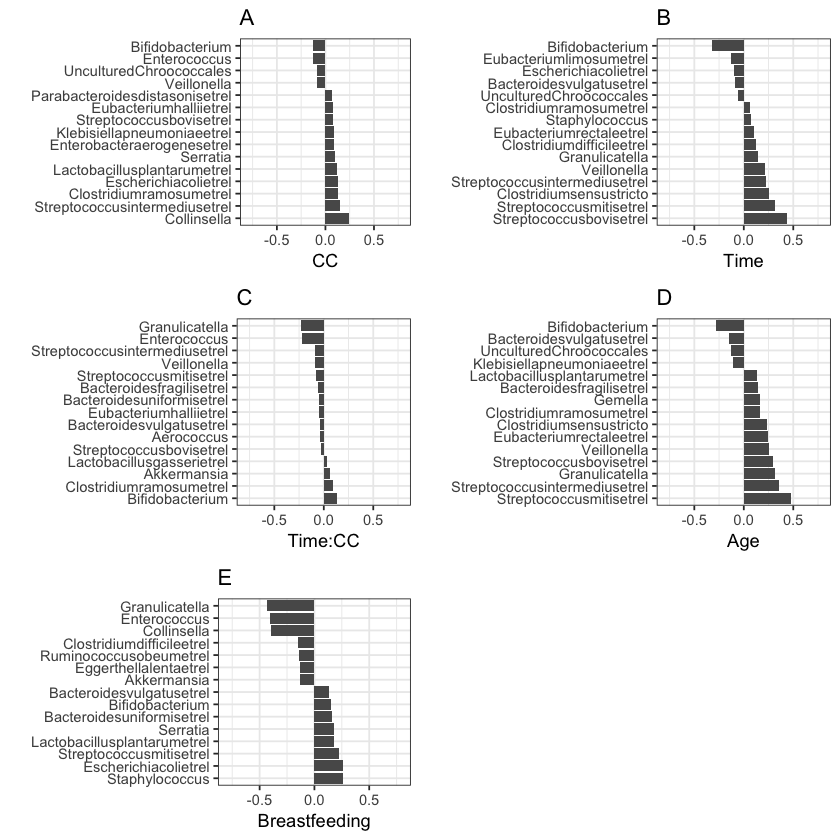

In [204]:
coef_v <- c("cc1", "time1", "time1:cc1", "age_d_s", "bf_count_s")
coef_title <- c("CC", "Time", "Time:CC", "Age", "Breastfeeding")
pmps <- map2(coef_v, coef_title, function(.x, .y) {
    coef <- pms[[1]]$coefs[.x,] 
    # make plot that I can manipulate better for apa6th in case
    coef_top <- 
        coef[rev(order(abs(coef)))[1:15]] %>%
        as.data.frame() %>%
        rownames_to_column("top_taxa") 
    colnames(coef_top) <- c("top_taxa", "coef_top")

    coef_top <- coef_top %>% arrange(desc(coef_top)) %>%
                mutate(top_taxa = factor(top_taxa, levels = top_taxa))
     p <- ggplot(coef_top, aes(top_taxa, coef_top)) +
            geom_bar(stat="identity") +
            ylim(-0.8, 0.8) +
            xlab("") + ylab(.y) +
            ggtitle(glue::glue("Coefficient: {.x}")) +
            coord_flip() +
            theme_bw()
    ggsave(here(glue("fig/permanova_{.x}_clr.png")))
    p
})
ggpubr::ggarrange(
    pmps[[1]] + ggtitle('A'), 
    pmps[[2]] + ggtitle('B'), 
    pmps[[3]] + ggtitle('C'), 
    pmps[[4]] + ggtitle('D'), 
    pmps[[5]] + ggtitle('E'), 
    nrow = 3, ncol = 2, common.legend = T)


# Hierarchical Generalized Linear Models

In [205]:
future::availableCores()

system 
     8

In [206]:
#devtools::install_github("paul-buerkner/brms")
library(brms)

## Alpha diversity regressed on X

I started with a prior of exp(10). From my limited experience, models will converge if I use a strong prior here. The prior assigns low probability to high variation of the distribution of the intercepts and slopes per individual.

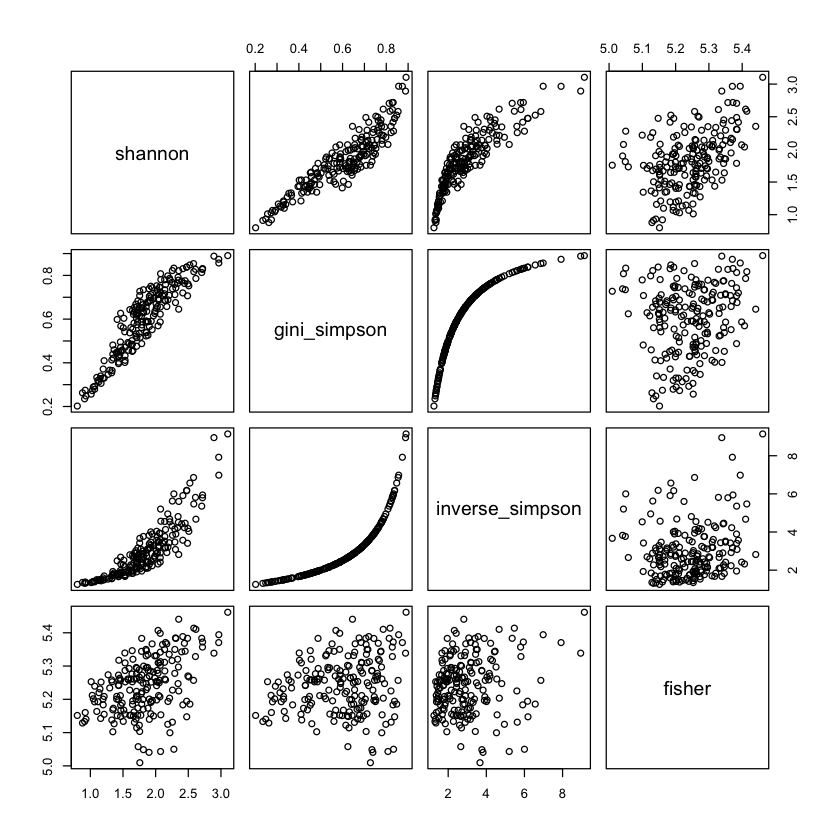

shannon   gini_simpson inverse_simpson fisher   
shannon         1.0000000 0.9164823    0.8751892       0.4663426
gini_simpson    0.9164823 1.0000000    0.8733147       0.1690157
inverse_simpson 0.8751892 0.8733147    1.0000000       0.1793241
fisher          0.4663426 0.1690157    0.1793241       1.0000000

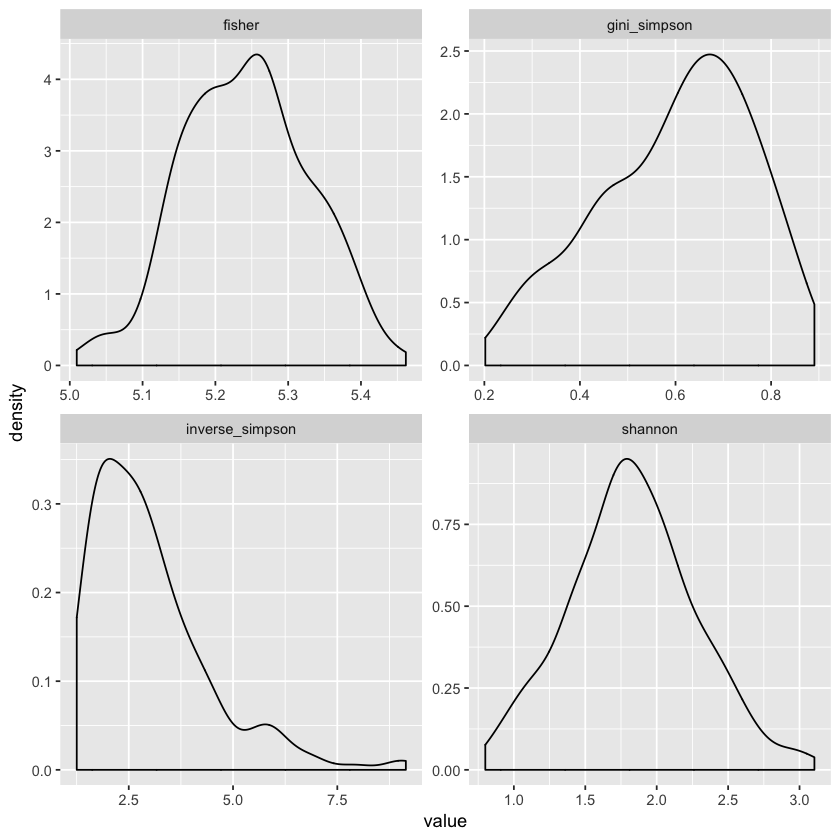

In [207]:
data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    pairs()

data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    gather(index, value) %>%
    ggplot(aes(value)) +
    geom_density() +
    facet_wrap(~index, scales = "free")

data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    cor()

In [208]:
folder <- here("models/alpha_diversity")
diversity_index <- c("shannon", "inverse_simpson", "gini_simpson")

### Model specification
I will define different models using either gaussian or skew_normal distribution and also using either the integrated missing value treatment from BRMS or not. The rationale behind using it is that I will have more power to evaluate the hypotheses whether CC has effect on MB. Breastfeeding is a covariate and the uncertainty introduced imputation will be reflected in the posterior. 

The skew_normal should better be able to deal with the inverse simpson but in the end both should be fine.

In [209]:
# # create directories
# lapply(diversity_index, function(x) {
#     dir.create(glue("{folder}/{x}"))
#     dir.create(glue("{folder}/{x}/gaussian"))
#     dir.create(glue("{folder}/{x}/skew_normal"))
# })

In [210]:
prior <- 
    c(
        set_prior("normal(0, 1)", class = "b"),
        set_prior("exponential(20)", class = "sd"),
        set_prior("normal(0, 10)", class = "Intercept"),
        set_prior("lkj(2)", class = "cor")
    )
prior_skew <- 
    c(
        set_prior("normal(0, 1)", class = "b"),
        set_prior("exponential(25)", class = "sd"),
        set_prior("normal(0, 10)", class = "Intercept"),
        set_prior("lkj(2)", class = "cor")
    )
brm_div <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/gaussian/full")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15),
            prior = prior, file = model_file
        )
}


brm_div_multiple <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/gaussian/full_multiple")
        #fit model
        brm_multiple(
            family = gaussian(), data = data_imp, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15),
            prior = prior, file = model_file
        )
}

brm_div_multiple_skew <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full_multiple_skew")
        #fit model
        brm_multiple(
            family = skew_normal(), data = data_imp, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15),
            prior = prior_skew, file = model_file
        )
}


brm_div_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(15)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/{diversity_index}/gaussian/full_mi")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

brm_div_skew <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999), 
            prior = prior, file = model_file
        )
}


brm_div_skew_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior 
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(15)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts"))
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full_mi")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

In [211]:
glue("{folder}/{diversity_index}/gaussian/full_multiple")

/Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo/models/alpha_diversity/shannon/gaussian/full_multiple
/Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo/models/alpha_diversity/inverse_simpson/gaussian/full_multiple
/Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo/models/alpha_diversity/gini_simpson/gaussian/full_multiple

In [212]:
#pp_div_m_skew <- future_map2(div_models_m_skew, diversity_index, ~pp_plot(.x, 10, .y))
#pp_div_m_v2_skew <- future_map2(div_models_m_skew, diversity_index, ~pp_plot_v2(.x, 10, .y))
#pp_div_m_skew
#pp_div_m_v2_skew

In [213]:
#pp_div_m <- future_map2(div_models_m, diversity_index, ~pp_plot(.x, 10, .y))
#pp_div_m_v2 <- future_map2(div_models_m, diversity_index, ~pp_plot_v2(.x, 10, .y))
#pp_div_m
#pp_div_m_v2

In [214]:
# use this for brm multiple
calc_treatment_effect_div <- function(div, summarise = TRUE, stat = "mean") {
    model <- brm_div_multiple_skew(div)
    df <- posterior_samples(model) %>%
        select(
            glue("b_Intercept"), 
            glue("b_ccyes"), 
            glue("b_timepost"), 
            glue("b_ccyes:timepost")) %>%
        rename(
            noccpre = glue("b_Intercept"), 
            ccpre = glue("b_ccyes"),
            noccpost = glue("b_timepost"),
            ccpost = glue("b_ccyes:timepost")) %>%
        mutate(
            ccpost = noccpre + ccpre + noccpost + ccpost,
            noccpost = noccpre + noccpost,
            ccpre = noccpre + ccpre)   %>%
    select(noccpre, ccpre, noccpost, ccpost)
    if (summarise) {
        df <- df %>% gather(group, value) %>%
            group_by(group) %>%
            do(data.frame(
                central = ifelse(stat == "median", median(.$value), mean(.$value)),
                lower = hpdi(.$value)[1],
                upper = hpdi(.$value)[2]
            ))
    }
    df
}


In [215]:
compare_groups_div <- function(df_div) {
    df <- calc_treatment_effect(div, summarise = F)
    df <- df %>% 
        mutate(            
            ccpost_ccpre = ccpost - ccpre,
            ccpost_noccpre = ccpost - noccpre,
            ccpost_noccpost = ccpost - noccpost,
            ccpre_noccpre = ccpre - noccpre,
            noccpost_noccpre = noccpost - noccpre,
            noccpost_ccpre = noccpost - ccpre) %>%
        select(ccpost_ccpre, ccpost_noccpre, ccpost_noccpost, ccpre_noccpre, noccpost_noccpre, noccpost_ccpre) %>%
        gather(comparison, value) %>%
        group_by(comparison) %>%
        do(data.frame(
            mean_diff = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2],
            prob = mean(.$value < 0)
        ))
    df
}

In [216]:
df_div <- map(diversity_index, calc_treatment_effect_div, FALSE)
df_sum_div <- map(diversity_index, calc_treatment_effect_div, TRUE)

In [256]:
df_div %>% head()

[[1]]
       noccpre    ccpre noccpost   ccpost
1     1.828498 1.998893 1.849368 1.557135
2     1.874153 1.837453 1.850377 1.704775
3     1.938808 2.028354 1.805875 1.475183
4     1.837406 1.915390 1.854569 1.633601
5     1.947733 1.948581 1.809319 1.505662
6     1.870824 1.842123 1.772737 1.658570
7     1.880760 1.931724 1.808892 1.526222
8     1.739953 1.982376 1.856501 1.802030
9     1.984270 1.883421 1.966078 1.585346
10    1.732503 1.954458 1.905331 1.793148
11    1.695267 1.905273 1.940035 1.816672
12    1.740203 1.932710 1.839671 1.727569
13    1.948909 1.926814 1.955861 1.648743
14    1.962169 2.034904 1.885329 1.503079
15    1.793204 2.004360 1.800847 1.538903
16    1.915213 1.768519 1.854304 1.718855
17    1.867700 2.048672 1.888297 1.601868
18    1.887668 2.004783 1.776910 1.687298
19    1.956638 1.944506 1.936974 1.692938
20    1.777561 1.822476 1.858388 1.663059
21    1.968404 1.948305 1.905901 1.636116
22    1.901608 2.029938 1.818605 1.584881
23    1.886927 1.847322 1.905208 1.624925
24    1.998648 1.870459 1.930895 1.547344
25    1.767315 1.950399 1.786116 1.780165
26    1.876117 1.961080 1.849293 1.704455
27    1.853066 1.930779 1.954639 1.729652
28    1.885994 1.792168 1.803080 1.638794
29    1.846029 1.968439 1.838375 1.691044
30    1.808966 1.971377 1.759902 1.720502
31    1.827937 1.917607 1.789886 1.686706
32    1.934611 1.921269 1.800018 1.541665
33    1.939765 2.034800 1.823455 1.590966
34    1.767907 1.906109 1.852665 1.707929
35    1.745428 1.938428 1.823367 1.698715
36    1.964167 1.971846 1.899302 1.597187
37    1.736092 1.788726 1.912872 1.688639
38    1.907642 1.968281 1.924164 1.756746
39    1.881265 1.962417 1.890817 1.634722
40    1.903473 1.925889 1.893464 1.669222
41    1.893724 1.993903 1.797342 1.662126
42    1.824639 1.837666 1.948545 1.776328
43    1.927213 1.938628 1.848878 1.614790
44    1.888423 1.893205 1.886619 1.569014
45    1.805787 1.936999 1.729539 1.646877
46    1.957910 2.001542 1.916864 1.609798
47    1.894978 1.926521 1.827555 1.758504
48    1.807436 1.862656 1.883600 1.635891
49    1.983755 1.896914 1.841271 1.617649
50    1.834324 1.966854 1.859357 1.692778
51    1.887394 1.789192 1.874551 1.532512
52    1.992423 1.900814 1.748546 1.622006
53    1.756852 1.956419 1.858541 1.629101
54    1.976913 1.783061 1.807471 1.570941
55    1.961090 1.887899 1.845173 1.487268
56    1.934193 1.855851 1.809502 1.515911
57    1.824825 1.977568 1.831189 1.693480
58    2.050828 1.893412 1.850334 1.512407
59    1.832292 1.875020 1.884360 1.663923
60    2.027320 1.992172 1.902200 1.666031
61    1.780149 1.895986 1.816782 1.579371
62    1.873506 1.934498 1.760042 1.794944
63    1.797229 1.881768 1.898241 1.578094
64    1.876264 1.904969 1.795040 1.802919
65    1.915235 2.055612 1.928830 1.601152
66    1.897246 1.811075 1.743905 1.677397
67    1.971289 1.984237 1.918261 1.582225
68    1.933690 1.852705 1.808264 1.663906
69    1.913935 1.921352 1.919895 1.486969
70    1.956709 1.891503 1.880937 1.786302
71    1.923790 1.944443 1.802769 1.601461
72    1.777659 1.773703 1.914511 1.635572
73    2.008544 1.998917 1.818370 1.516090
74    1.709542 1.726238 1.921041 1.735906
75    1.875544 1.951949 1.835877 1.654920
76    1.986595 1.996162 1.908660 1.727380
77    1.888854 1.939061 1.937071 1.628947
78    1.872059 1.843187 1.897145 1.760978
79    1.868038 1.913790 1.937894 1.612720
80    1.861068 1.974821 1.889153 1.741702
81    1.943700 2.034581 1.785107 1.519636
82    1.906108 1.883600 1.943010 1.736197
83    1.877046 2.011044 1.779001 1.622033
84    2.087660 2.031368 1.778330 1.634433
85    1.965373 1.866239 1.893611 1.617562
86    1.813046 1.853131 1.808352 1.545696
87    1.939130 1.977187 1.951221 1.523102
88    1.924270 1.798648 1.915587 1.765206
89    1.886881 1.999343 1.857354 1.532664
90    1.764799 1.765047 1.805317 1.767107
91    2.000930 1.984545 1.911518 1.613745
92    1.965915 1.929711 1.770249 1.622903
93    1.781059 1.880494 1.951656 1.751628
94    2.018559 2.009710 1.809706 1.675856
95  

In [299]:
# change group names for plotting
data <- data %>% mutate(
    group = ifelse(groups == "noCCpost", "noccpost", ifelse(groups == "CCpost", "ccpost", ifelse(groups == "CCpre", "ccpre", "noccpre"))))
# visualize difference
plot_effects <- function(div, df_div, data = data) {
    title = gsub("_", " ", div)
    title = str_to_title(title)
    df_div_gathered <- df_div %>% gather(group, value)
    data %>% mutate(subject_id = as.factor(subject_id)) %>%
    ggplot(aes_string("group", div, group = "subject_id")) +
        geom_point(alpha = 0.3, size = 0.5) +
        geom_path(alpha = 0.3, size = 0.25) +
        geom_jitter(data = df_div_gathered, aes(x = group, y = value, group = ""), width = 0.05, alpha = 0.01, color = "#ef8a62") +
        scale_x_discrete(limits=c("noccpre", "noccpost", "ccpre", "ccpost"), labels = c("HOME PRE", "HOME POST", "CC PRE", "CC POST")) +
        ylab(title) + xlab("") +
        theme_bw()
}

p_div <- map2(diversity_index, df_div, plot_effects, data)

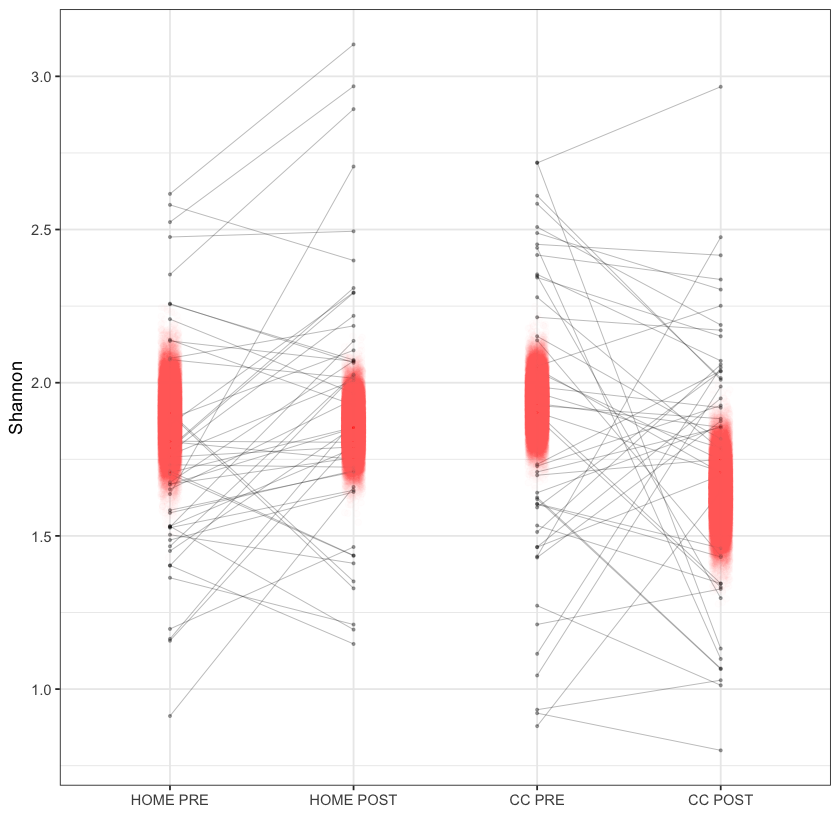

In [300]:
p_div[[1]]

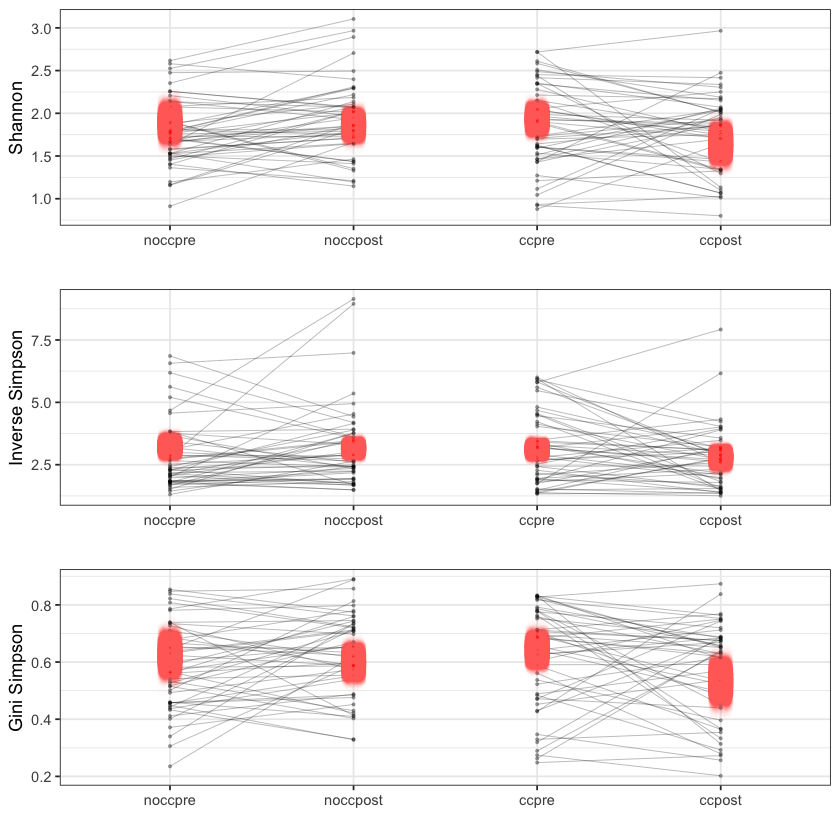

In [265]:
ggarrange(p_div[[1]], p_div[[2]], p_div[[3]], nrow = 3)


# Differential abundance testing

In [219]:
# specify prior (i did not specifiy sigma and alpha)
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))
prior_refit <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(55)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))
prior_refit2 <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(65)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))

prior_refit3 <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(75)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))

prior_refit4 <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(100)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))


control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
folder <- here("models/differential_abundance/skew_normal/mice/")

# define fitting function for fixed sigma for mice object
brm_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
    formula <- bf(f_d)
    # give individual model name for storage
    model_file <- glue("{folder}/{genus}_full_multiple")
    #fit model
    brm_multiple(
        family = skew_normal(), data = data_imp, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior, file = model_file
        )
    
}

brm_sn_multiple_fut <- function(genus) future({
    tryCatch(
        {
            # specify formula
            f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
            formula <- bf(f_d)
            # give individual model name for storage
            model_file <- glue("{folder}/{genus}_full_multiple")
            #fit model
            brm_multiple(
                family = skew_normal(), data = data_imp, formula = formula,
                chains = 4, warmup = 1000,
                control = control, prior = prior, file = model_file
                )
        },
        error=function(cond) {
            # Choose a return value in case of error
            return(cond)
        }
    )
})

brm_sn_multiple_fut_refit <- function(genus) future({
    tryCatch(
        {
            # specify formula
            f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
            formula <- bf(f_d)
            # give individual model name for storage
            model_file <- glue("{folder}/refit/{genus}_full_multiple")
            #fit model
            brm_multiple(
                family = skew_normal(), data = data_imp, formula = formula,
                chains = 4, warmup = 1000,
                control = control, prior = prior_refit4, file = model_file
                )
        },
        error=function(cond) {
            # Choose a return value in case of error
            return(cond)
        }
    )
})

# define fitting function for fixed sigma and imputation on the fly
brm_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
    formula <- bf(f_d)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior, file = model_file
        )
    
}
        
        
# define fitting function for fixed sigma
brm_sn_mi <- function(genus) {
        # delete _ for prior
        sub_prior <- gsub("_", "", genus)
        sub_prior <- gsub("\\.", "", sub_prior)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = sub_prior),
            set_prior("exponential(25)", class = "sd", resp = sub_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(25)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
    # specify formula
    f1 <- as.formula(glue("{genus} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
    f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {genus} + age_d_s + (1 + time + age_d_s + {genus}|subject_id)"))
    formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}
     

        
        
# specify prior 
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(25)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma"),
            set_prior("lkj(2)", class = "cor"))


control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
# folder 
folder_d <- here("models/cc_vs_nocc")

# define fitting function distributional
brmd_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
    formula_d <- bf(f_d, sigma ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id))
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_d_full")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = 4, warmup = 1000,
        control = control, prior = prior_d, file = model_file
        )
    
}

# define fitting function distributional + mi
brmd_sn_mi <- function(genus) {
    # delete _ for prior
    sub_prior <- gsub("_", "", genus)
    sub_prior <- gsub("\\.", "", sub_prior)
    # specify prior for mi version
    prior_n <- c(
        set_prior("normal(0, 2)", class = "b", resp = sub_prior),
        set_prior("exponential(15)", class = "sd", resp = sub_prior),
        set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
        set_prior("lkj(2)", class = "cor"),     
        set_prior("normal(0, 2)", class = "b", dpar = "sigma", resp = sub_prior),
        set_prior("exponential(25)", class = "sd", dpar = "sigma", resp = sub_prior),
        set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma", resp = sub_prior),
        set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
        set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
        set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
    )
    # specify formula
    f1 <- as.formula("Enterococcus |mi() ~ 1+ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)")
    f1 <- bf(f1, sigma ~ 1 + time*cc + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id))
    f2 <- as.formula("bf_count_s |mi() ~ 1 + cc*time + Enterococcus + age_d_s + (1 + time + age_d_s + Enterococcus|subject_id)")
    formula_d <- bf(f1) + bf(f2) + set_rescor(FALSE) 
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_d_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}

# this function I added for the exluded_id (see below)
# define fitting function for fixed sigma
brm_sn_mi_ex <- function(genus) {
        # delete _ for prior
        sub_prior <- gsub("_", "", genus)
        sub_prior <- gsub("\\.", "", sub_prior)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = sub_prior),
            set_prior("exponential(35)", class = "sd", resp = sub_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(35)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
    # specify formula
    f1 <- as.formula(glue("{genus} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
    f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {genus} + age_d_s + (1 + time + age_d_s + {genus}|subject_id)"))
    formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}

In [220]:
#plan(multiprocess)
#map(files[excluded_ids], brm_sn_multiple_fut_refit)
#models <- future_map(models_fut, value)

In [221]:
# model screening/excluding 
return_diag <- function(fit, genus) {
    sum_fit <- summary(fit)
    params <- rbind(sum_fit$fixed, sum_fit$random$subject_id, sum_fit$spec_pars) %>% as.data.frame()
    # extract n of divergent transitions
    n_divergent <- nuts_params(fit) %>% 
        filter(Parameter == "divergent__") %>% 
        summarise(n = sum(Value))
    # extract n of rhat > 1.1        
    n_high_rhat <- dim(filter(params, Rhat >= 1.1))[1]
    # check if there are rhat > 1.1 or divergent transitions
    if (n_high_rhat > 0) {
        message(glue("{genus} has {n_high_rhat} high Rhat parameter values"))
        return(FALSE)
    } else if (n_divergent$n > 0){
        message(glue("{genus} has {n_divergent$n} divergent transitions"))
        return(FALSE)
    } 
    TRUE
}

calc_mu_diff <- function(model, summarise = TRUE, stat = "mean") {
    df <- posterior_samples(model) %>%
        select(
            glue("b_Intercept"), 
            glue("b_ccyes"), 
            glue("b_timepost"), 
            glue("b_timepost:ccyes"), 
            glue("b_age_d_s"), 
            glue("b_bf_count_s")
        ) %>%
        rename(
            noccpre = glue("b_Intercept"), 
            ccpre = glue("b_ccyes"),
            noccpost = glue("b_timepost"),
            ccpost = glue("b_timepost:ccyes"),
            age = glue("b_age_d_s"),
            bf = glue("b_bf_count_s")
        ) %>%
        mutate(
            ccpost = noccpre + ccpre + noccpost + ccpost,
            noccpost = noccpre + noccpost,
            ccpre = noccpre + ccpre
    )    
    if (summarise) {
        df <- df %>% gather(group, value) %>%
            group_by(group) %>%
            do(data.frame(
                central = ifelse(stat == "median", median(.$value), mean(.$value)),
                lower = hpdi(.$value)[1],
                upper = hpdi(.$value)[2]
            ))
        
    }
    df 
}

plot_diff <- function(model) {
    df_sum <- calc_mu_diff(model)
    df <- calc_mu_diff(model, summarise = F)
    # plot
    df %>% gather(group, value) %>%
        ggplot(aes(x = group, value)) +
            geom_jitter(alpha = 0.05, color = "darkred") +
            geom_point(data = df_sum, aes(x = group, y = central), size = 2, color = "red") +
            geom_errorbar(data = df_sum, aes(x = group, y = central,  ymin = lower, ymax = upper), color = "darkred") +
            theme_bw()
}
compare_groups <- function(fit, genus) {
    df <- calc_mu_diff(fit,  summarise = F)
    df <- df %>% 
        mutate(            
            ccpost_ccpre = ccpost - ccpre,
            ccpost_noccpre = ccpost - noccpre,
            ccpost_noccpost = ccpost - noccpost,
            ccpre_noccpre = ccpre - noccpre,
            noccpost_noccpre = noccpost - noccpre,
            ccpre_noccpost = ccpre - noccpost) %>%
        select(ccpost_ccpre, ccpost_noccpre, ccpost_noccpost, ccpre_noccpre, noccpost_noccpre, ccpre_noccpost, age, bf) %>%
        gather(comparison, value) %>%
        group_by(comparison) %>%
        do(data.frame(
            mean = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2],
            prob = mean(.$value < 0)
        ))
    df %>% add_column(genus = genus)
}

return_comparisons <- function(genus) {
    fit_fut <- brm_sn_multiple_fut(genus)
    fit <- value(fit_fut)
    # can we go on with the model?
    if (!return_diag(fit, genus)) {
        return(genus = NA)
    }
    
    # else go on and compare groups
    compare_groups(fit, genus)
}

return_comparisons_refit <- function(genus) {
    fit_fut <- brm_sn_multiple_fut_refit(genus)
    fit <- value(fit_fut)
    # can we go on with the model?
    if (!return_diag(fit, genus)) {
        return(genus = NA)
    }
    
    # else go on and compare groups
    compare_groups(fit, genus)
}

In [222]:
#refit_gs <- gsub("_full_multiple.rds", "", list.files(here("models/differential_abundance/skew_normal/mice/refit")))

In [223]:
#for (genus in converged_models[excluded_ids]) {
#    fit_fut <- brm_sn_multiple_fut(genus)
#    fit <- values(fit_fut)
#    print(summary(fit))
#}

In [224]:
#map(refit_gs, ~file.remove(here(glue("models/differential_abundance/skew_normal/mice/{.x}_full_multiple.rds"))))
#map(genus_refit[excluded_ids], ~file.remove(here(glue("models/differential_abundance/skew_normal/mice/{.x}"))))

In [225]:
converged_models <- list.files(here(glue("models/differential_abundance/skew_normal/mice/")))
converged_models <- gsub("_full_multiple.rds", "", converged_models)
converged_models <- converged_models[-123]
converged_models

[1] "Actinomycetaceae"                  "Aerococcus"                       
  [3] "Aeromonas"                         "Akkermansia"                      
  [5] "Alcaligenesfaecalisetrel"          "Allistipesetrel"                  
  [7] "Anaerobiospirillum"                "Anaerofustis"                     
  [9] "Anaerostipescaccaeetrel"           "Anaerotruncuscolihominisetrel"    
 [11] "Anaerovoraxodorimutansetrel"       "Aneurinibacillus"                 
 [13] "Aquabacterium"                     "Asteroleplasmaetrel"              
 [15] "Bacillus"                          "Bacteroidesfragilisetrel"         
 [17] "Bacteroidesintestinalisetrel"      "Bacteroidesovatusetrel"           
 [19] "Bacteroidesplebeiusetrel"          "Bacteroidessplachnicusetrel"      
 [21] "Bacteroidesstercorisetrel"         "Bacteroidesuniformisetrel"        
 [23] "Bacteroidesvulgatusetrel"          "Bifidobacterium"                  
 [25] "Bilophilaetrel"                    "Brachyspira"                      
 [27] "Bryantellaformatexigensetrel"      "Bulleidiamooreietrel"             
 [29] "Burkholderia"                      "Campylobacter"                    
 [31] "Clostridiumcellulosietrel"         "Clostridiumcolinumetrel"          
 [33] "Clostridiumdifficileetrel"         "Clostridiumfelsineumetrel"        
 [35] "Clostridiumleptumetrel"            "Clostridiumorbiscindensetrel"     
 [37] "Clostridiumramosumetrel"           "Clostridiumsensustricto"          
 [39] "Clostridiumsphenoidesetrel"        "Clostridiumstercorariumetrel"     
 [41] "Clostridiumsymbiosumetrel"         "Clostridiumthermocellumetrel"     
 [43] "Collinsella"                       "Coprobacilluscatenaformisetrel"   
 [45] "Coprococcuseutactusetrel"          "Corynebacterium"                  
 [47] "Desulfovibrioetrel"                "Dialister"                        
 [49] "Doreaformicigeneransetrel"         "Eggerthellalentaetrel"            
 [51] "Enterobacteraerogenesetrel"        "Enterococcus"                     
 [53] "Escherichiacolietrel"              "Eubacteriumbiformeetrel"          
 [55] "Eubacteriumcylindroidesetrel"      "Eubacteriumhalliietrel"           
 [57] "Eubacteriumlimosumetrel"           "Eubacteriumrectaleetrel"          
 [59] "Eubacteriumsiraeumetrel"           "Eubacteriumventriosumetrel"       
 [61] "Faecalibacteriumprausnitziietrel"  "Fusobacteria"                     
 [63] "Gemella"                           "Granulicatella"                   
 [65] "Haemophilus"                       "Helicobacter"                     
 [67] "Klebisiellapneumoniaeetrel"        "Lachnobacillusbovisetrel"         
 [69] "Lachnospirapectinoschizaetrel"     "Lactobacilluscatenaformisetrel"   
 [71] "Lactobacillusgasserietrel"         "Lactobacillusplantarumetrel"      
 [73] "Lactobacillussalivariusetrel"      "Lactococcus"                      
 [75] "Leminorella"                       "Megamonashypermegaleetrel"        
 [77] "Megasphaeraelsdeniietrel"          "Methylobacterium"                 
 [79] "Micrococcaceae"                    "Mitsuokellamultiacidaetrel"       
 [81] "Moraxellaceae"                     "Novosphingobium"                  
 [83] "Oceanospirillum"                   "Oscillospiraguillermondiietrel"   
 [85] "Oxalobacterformigenesetrel"        "Papillibactercinnamivoransetrel"  
 [87] "Parabacteroidesdistasonisetrel"    "Peptococcusnigeretrel"            
 [89] "Peptostreptococcusanaerobiusetrel" "Peptostreptococcusmicrosetrel"    
 [91] "Phascolarctobacteriumfaeciumetrel" "Prevotellamelaninogenicaetrel"    
 [93] "Prevotellaoralisetrel"             "Prevotellaruminicolaetrel"        
 [95] "Prevotellatanneraeetrel"           "Propionibacterium"                
 [97] "Proteusetrel"                      "Pseudomonas"                      
 [99] "Roseburiaintestinalisetrel"        "Ruminococcusbromiietrel"          
[101] "Ruminococcuscallidusetrel"         "Ruminococcusgnavusetrel"          
[103] "Ruminococcusobeum

In [226]:
plan(multiprocess)
comp_all <- future_map(converged_models, return_comparisons)

In [227]:
# I used this until all models converged
excluded_ids <- which(is.na(comp_all))
converged_models[excluded_ids]
comp_all_complete <- comp_all[!is.na(comp_all)]
length(comp_all)
#map(files[excluded_ids], ~file.remove(here(glue("models/differential_abundance/skew_normal/mice/{.x}_full_multiple.rds"))))
comp_all %>% head(2)

character(0)

[1] 122

[[1]]
# A tibble: 8 x 6
# Groups:   comparison [8]
  comparison           mean    lower  upper   prob genus           
  <chr>               <dbl>    <dbl>  <dbl>  <dbl> <chr>           
1 age              -0.0322  -0.107   0.0458 0.801  Actinomycetaceae
2 bf               -0.0204  -0.0718  0.0298 0.788  Actinomycetaceae
3 ccpost_ccpre      0.0715  -0.0631  0.207  0.148  Actinomycetaceae
4 ccpost_noccpost   0.101   -0.00992 0.209  0.0358 Actinomycetaceae
5 ccpost_noccpre    0.0974  -0.0867  0.279  0.149  Actinomycetaceae
6 ccpre_noccpost    0.0296  -0.0960  0.156  0.323  Actinomycetaceae
7 ccpre_noccpre     0.0259  -0.0749  0.131  0.309  Actinomycetaceae
8 noccpost_noccpre -0.00367 -0.136   0.129  0.521  Actinomycetaceae

[[2]]
# A tibble: 8 x 6
# Groups:   comparison [8]
  comparison           mean   lower   upper   prob genus     
  <chr>               <dbl>   <dbl>   <dbl>  <dbl> <chr>     
1 age               0.0527  -0.0201  0.122  0.0734 Aerococcus
2 bf               -0.0682  -0.112  -0.0228 0.998  Aerococcus
3 ccpost_ccpre     -0.0801  -0.216   0.0498 0.882  Aerococcus
4 ccpost_noccpost  -0.0301  -0.138   0.0752 0.708  Aerococcus
5 ccpost_noccpre   -0.00543 -0.180   0.170  0.529  Aerococcus
6 ccpre_noccpost    0.0500  -0.0714  0.180  0.214  Aerococcus
7 ccpre_noccpre     0.0747  -0.0388  0.187  0.0930 Aerococcus
8 noccpost_noccpre  0.0247  -0.116   0.167  0.372  Aerococcus

In [228]:
comp_all_df <- map_df(comp_all_complete, bind_rows)

# the input for the plot_comp function will be nested dfs:
comp_all_nested <- comp_all_df %>% 
    group_by(comparison) %>%
    nest()

plot_comp <- function(data, comp) {
    all_comp <- data %>% mutate(prob = report_star_nondirectional(prob))
    n_genera <- length(all_comp$genus)
    part1 <- all_comp[1:n_genera/2, ]
    part2 <- all_comp[-c(1:n_genera/2), ]
    p <- map(list(part1, part2), ~ ggplot(
        .x, aes(genus, mean, label = prob)) +
        geom_pointrange(aes(ymin = lower, ymax = upper), size = 0.2) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_text(nudge_y = 1) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
        ylim(-2, 2) +
        ggtitle(comp) +
        coord_flip() +
        theme_bw(base_size = 8))
    
    p
}


comparison_plots <- map2(comp_all_nested$data, comp_all_nested$comparison, plot_comp)


In [229]:
comp_article %>% filter(prob <= 0.05 | prob >= 0.95, comparison == "ccpost_noccpost", genus == "Streptococcusintermediusetrel")

comparison      mean       lower      upper       prob   
1 ccpost_noccpost -0.2875031 -0.5593308 -0.01669883 0.98115
  genus                        
1 Streptococcusintermediusetrel

[1] "age"              "bf"               "ccpost_ccpre"     "ccpost_noccpost" 
[5] "ccpost_noccpre"   "ccpre_noccpost"   "ccpre_noccpre"    "noccpost_noccpre"

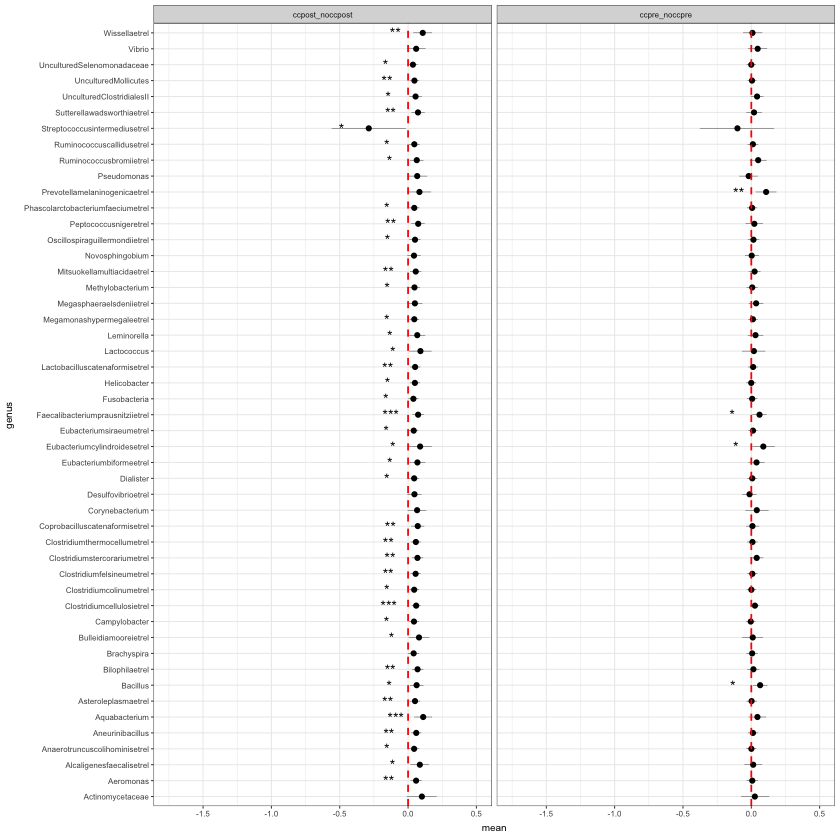

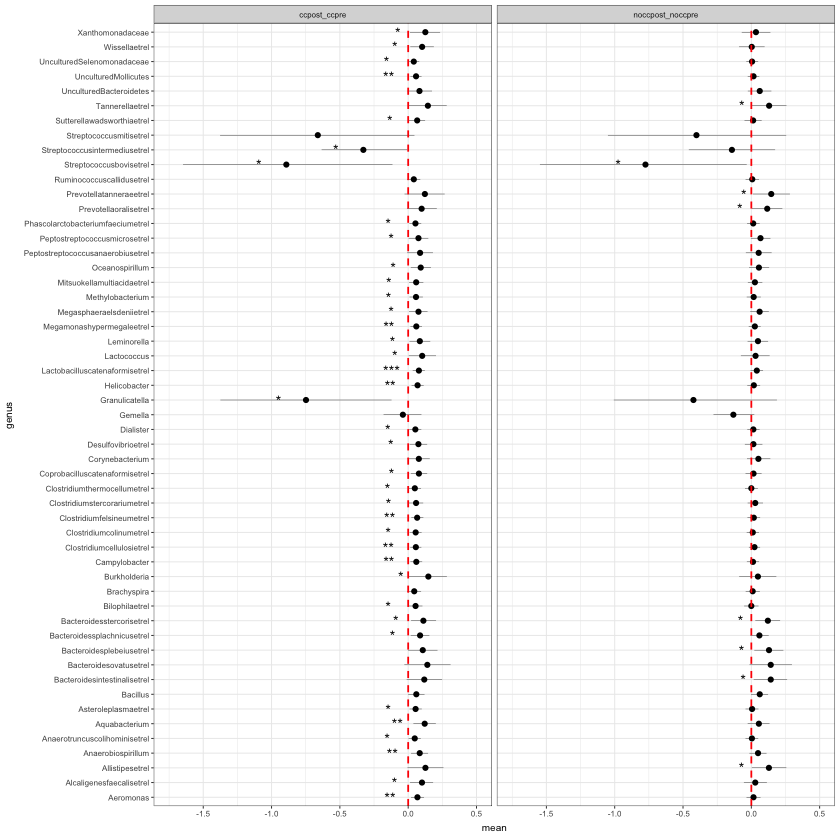

In [230]:
unique(comp_all_df$comparison)

comp_article_1 <- comp_all_df %>% filter(comparison  %in% c("ccpre_noccpre", "ccpost_noccpost"))
comp_article_2 <- comp_all_df %>% filter(comparison  %in% c("ccpost_ccpre", "noccpost_noccpre"))

filter_genus_1 <- comp_article_1 %>% 
    filter((comparison == "noccpre_ccpre" & (prob <= 0.05 | prob >= 0.95)) | (comparison == "ccpost_noccpost" & (prob <= 0.05 | prob >= 0.95)))
filter_genus_2 <- comp_article_2 %>% 
    filter((comparison == "ccpost_ccpre" & (prob <= 0.05 | prob >= 0.95)) | (comparison == "noccpost_noccpre" & (prob <= 0.05 | prob >= 0.95)))

plot_comp_article <- function(data, filter_genus) {
    all_comp <- data %>% mutate(prob = report_star_nondirectional(prob)) %>%
        filter(genus %in% filter_genus$genus)
    
    p <- ggplot(all_comp, aes(genus, mean, label = prob)) +
        geom_pointrange(aes(ymin = lower, ymax = upper), size = 0.1) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_text(nudge_y = - 0.2, size = 3) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
        ylim(-1.75, 0.5) +
        facet_wrap(~comparison) +
        coord_flip() +
        theme_bw(base_size = 6)
    
    p
}
comparison_plots_article_1 <- plot_comp_article(comp_article_1, filter_genus_1)
comparison_plots_article_2 <- plot_comp_article(comp_article_2, filter_genus_2)

comparison_plots_article_1
comparison_plots_article_2

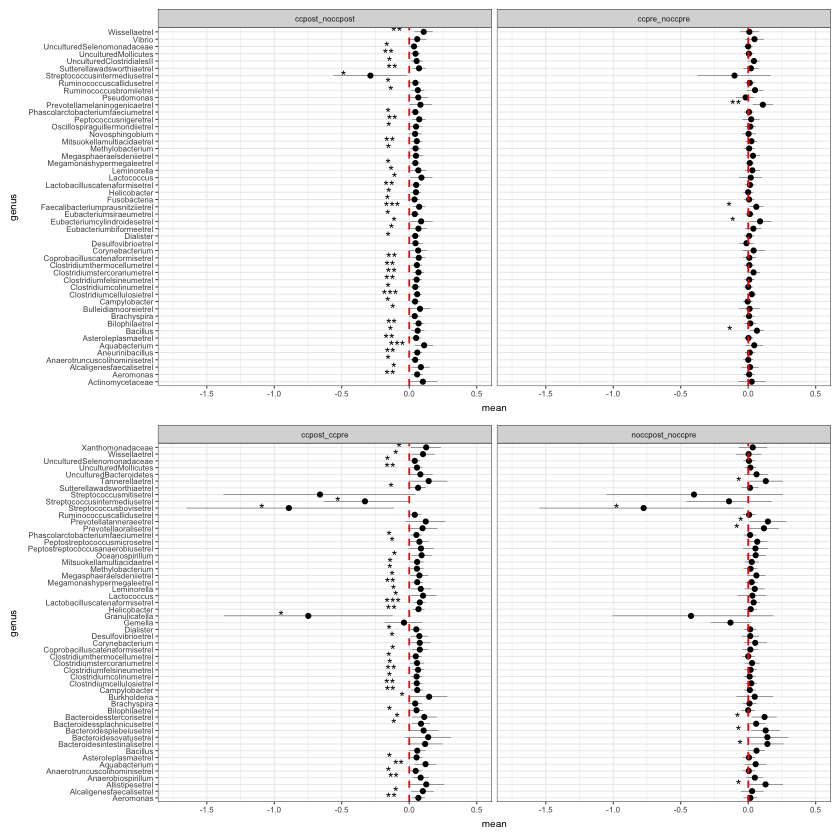

In [231]:
library(patchwork) 
comparison_plots_article / comparison_plots_article_2

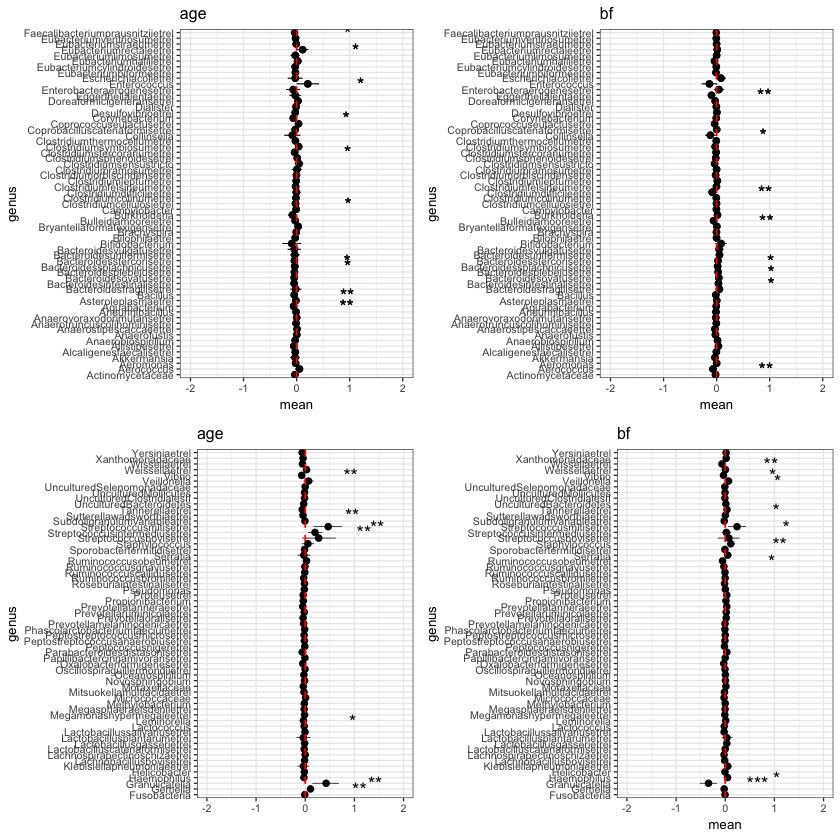

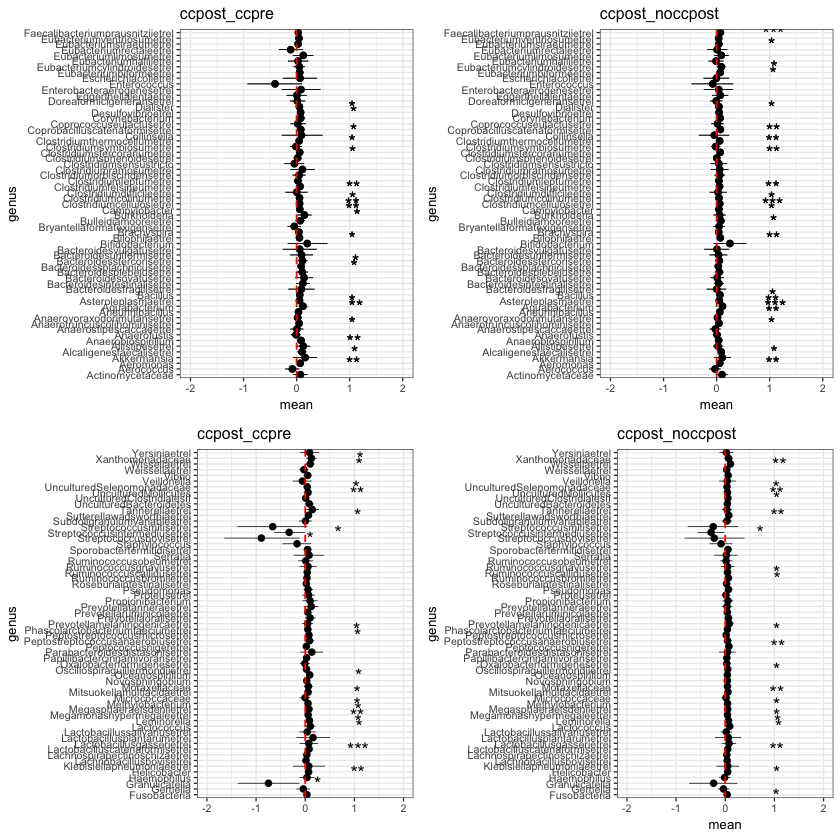

In [232]:
library(ggpubr)
ggarrange(
    comparison_plots[[1]][[1]], comparison_plots[[2]][[1]],
    comparison_plots[[1]][[2]] + ylab(""), comparison_plots[[2]][[2]],
    nrow = 2, ncol = 2, common.legend = T
)


ggarrange(
    comparison_plots[[3]][[1]], comparison_plots[[4]][[1]],
    comparison_plots[[3]][[2]] + ylab(""), comparison_plots[[4]][[2]],
    nrow = 2, ncol = 2, common.legend = T
)

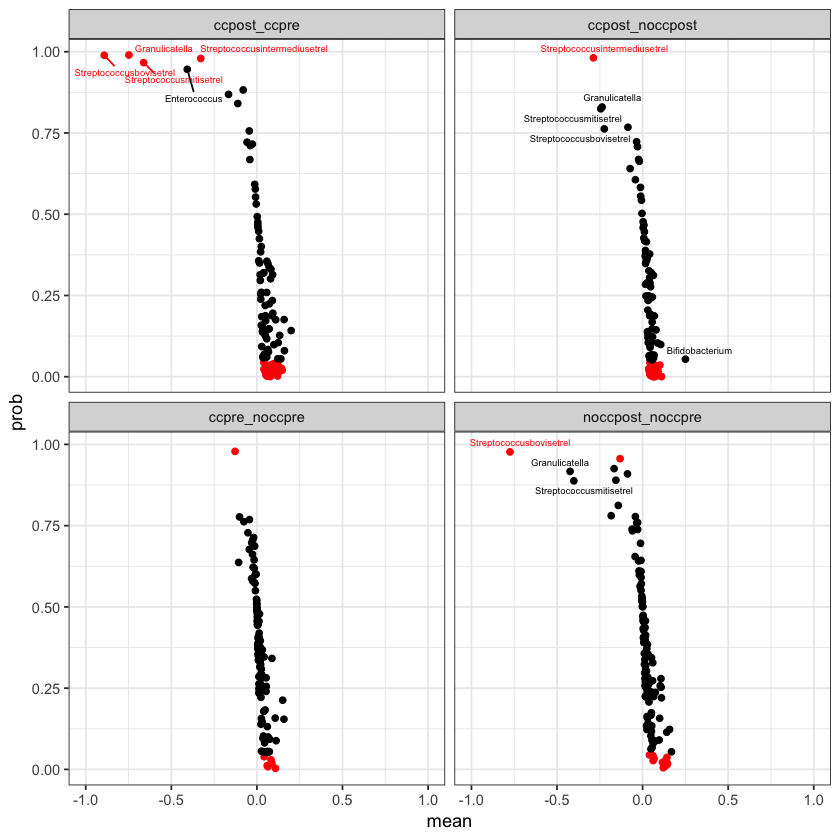

In [233]:
library(ggrepel)

differential_abundance_plots <- map2(comp_all_nested$data, comp_all_nested$comparison, ~.x %>% 
    arrange(prob) %>% 
    mutate(qvalue = cummean(prob)) %>%
    ggplot(aes(mean, prob, color = ifelse(prob <= 0.025 | prob >= 0.975, "sig", "notsig"), label = ifelse(abs(mean)>= 0.2, genus, ""))) +
        geom_point() + 
        xlim(-1, 1) +
        ggtitle(.y) +
        scale_colour_manual(values = c("sig" = "red", "notsig" = "black")) +
        geom_text_repel() +
        theme_bw() +
        theme(legend.position="none") 
   
   )
#differential_abundance_plots

comp_article <- comp_all_df %>% filter(comparison %in% c("ccpre_noccpre", "ccpost_noccpost", "ccpost_ccpre", "noccpost_noccpre"))

differential_abundance_plots_article <- comp_article %>% 
    arrange(prob) %>% 
    mutate(qvalue = cummean(prob)) %>%
    ggplot(aes(mean, prob, color = ifelse(prob <= 0.05 | prob >= 0.95, "sig", "notsig"), label = ifelse(abs(mean)>= 0.2, genus, ""))) +
        geom_point() + 
        xlim(-1, 1) +
        scale_colour_manual(values = c("sig" = "red", "notsig" = "black")) +
        geom_text_repel(size = 2) +
        facet_wrap(~comparison) +
        theme_bw() +
        theme(legend.position="none") 
differential_abundance_plots_article

In [294]:
# how often do we find differences per parameter/comparison?
comp_all_df %>%
    filter(prob < 0.025 | prob > 0.975) %>%
    group_by(comparison) %>%
    summarise(n = n())


comp_all_df %>%
    filter(prob < 0.025 | prob > 0.975, abs(mean) >= 0.15, comparison %in% c("ccpre_noccpre", "ccpost_noccpost", "ccpost_ccpre", "noccpost_noccpre", "bf", "age")) %>%
    select(-prob) %>%
    arrange(desc(abs(mean))) %>%
    mutate_if(is.numeric, round, 2)

comparison       n 
1 age              17
2 bf               17
3 ccpost_ccpre     38
4 ccpost_noccpost  40
5 ccpost_noccpre   36
6 ccpre_noccpost    1
7 ccpre_noccpre     5
8 noccpost_noccpre  8

comparison       mean  lower upper genus                        
1  ccpost_ccpre     -0.89 -1.65 -0.11 Streptococcusbovisetrel      
2  noccpost_noccpre -0.77 -1.55 -0.03 Streptococcusbovisetrel      
3  ccpost_ccpre     -0.75 -1.37 -0.12 Granulicatella               
4  age               0.47  0.17  0.76 Streptococcusmitisetrel      
5  age               0.42  0.15  0.68 Granulicatella               
6  bf               -0.34 -0.52 -0.17 Granulicatella               
7  ccpost_ccpre     -0.33 -0.63 -0.01 Streptococcusintermediusetrel
8  ccpost_noccpost  -0.29 -0.56 -0.02 Streptococcusintermediusetrel
9  bf                0.24  0.06  0.42 Streptococcusmitisetrel      
10 age               0.21  0.00  0.42 Enterococcus                 
11 age               0.20  0.06  0.35 Streptococcusintermediusetrel

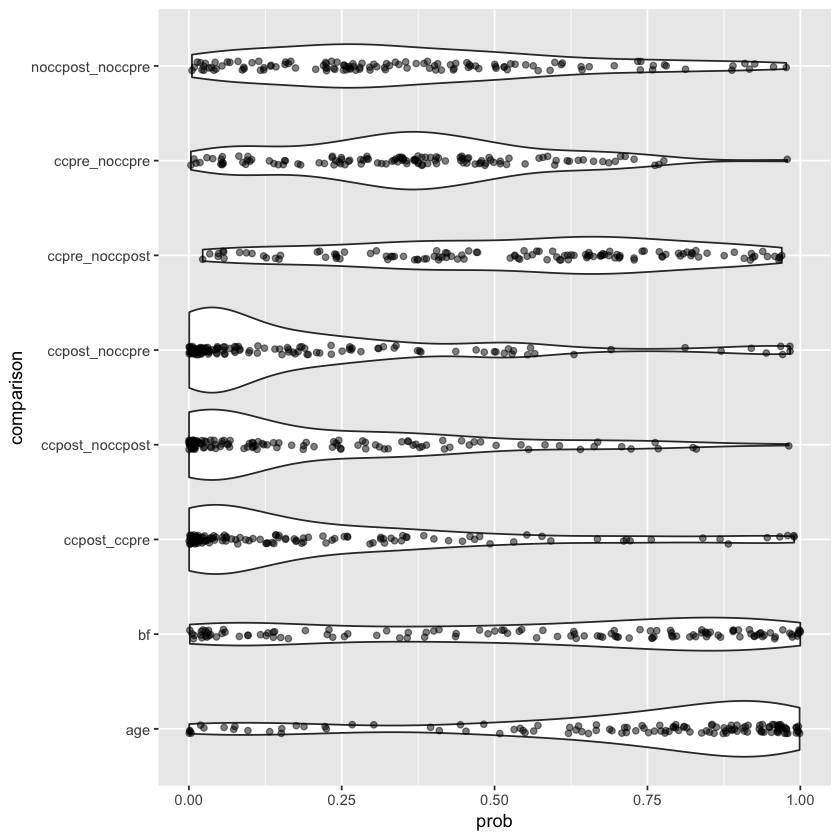

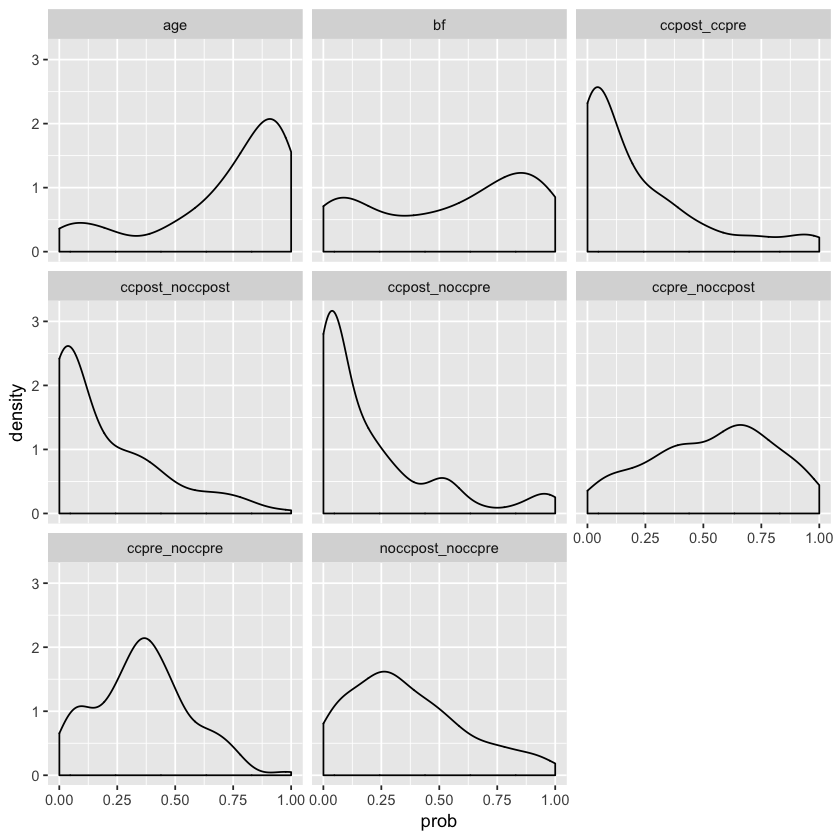

In [235]:
# how are the probabilities distributes? In my understanding, if there is no difference between ccpost
# and the other groups, thus the parameter mu is the same, then the probability that group difference is <0 should be close to 50%. 
# If the parameters where not similar but in a non-systematic way, then p should be uniformly distributed ?!
# But if there is a systematic difference I would expect p mostly either < 0.05 or >0.95
comp_all_df %>%
    ggplot(aes(comparison, prob)) +
    geom_violin() +
    geom_jitter(alpha = 0.5, width = 0.05) +
    coord_flip()

comp_all_df %>% 
    ggplot(aes(prob)) +
    geom_density() +
    facet_wrap(~comparison)

### Differential abundance LME4

In [236]:
library(lme4)
library(car)
library(qvalue)

In [237]:
# change contrasts for easy interpretability
reverse_c <- function(data) {
    contrasts(data$cc)[1, 1] <- 1
    contrasts(data$cc)[2, 1] <- 0
    contrasts(data$time)[1, 1] <- 1
    contrasts(data$time)[2, 1] <- 0
    data
}
data_imp_revc <- map(data_imp, reverse_c)

In [238]:
# test if it worked
data_imp_revc[[1]]$time %>% contrasts()

post
pre  1   
post 0

In [239]:
plan(multiprocess)
# fit models and pool estimates
lme4_fits <- 
    future_map(genus[-1], ~ data_imp_revc %>%
      map(lmer, formula = glue("{.x} ~ cc*time + age_d_s + bf_count_s + (1|subject_id)")) %>%
      pool() %>%
      summary() %>%
      rownames_to_column("parameter") %>%
      mutate(parameter = c("intercept", "cc", "time", "age", "breastfeeding", "cc_time")) %>%
      add_column(genus = .x) 
    )

R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call


In [240]:
lme4_by_param <- lme4_fits %>% 
    map_df(bind_rows) %>%
    filter(parameter != "intercept") %>%
    group_by(parameter) %>%
    nest()

In [241]:
lme4_by_param$parameter

[1] "cc"            "time"          "age"           "breastfeeding"
[5] "cc_time"

In [242]:
# calculate q value for each set of parameters, allow for 25% false discoveries
lme4_by_param$data <- map(lme4_by_param$data, ~.x %>% mutate(q = qvalue(p.value)$qvalue))

lme4_final <- lme4_by_param %>% unnest()
lme4_table <- lme4_final %>% 
    filter(p.value<=0.05, q <= 0.2) %>%
    arrange(parameter, desc(abs(estimate))) %>%
    mutate_if(is.numeric, round, 2) %>%
    select(parameter, genus, everything())

In [243]:
library(ggrepel)

params <- c("cc", "time", "age", "breastfeeding")

plot_comp <- function(comp, data) {
    all_comp <- data %>% mutate(p = report_star(p.value)) %>% filter(parameter == comp)
    n_genera <- length(all_comp$genus)
    part1 <- all_comp[1:n_genera/2, ]
    part2 <- all_comp[-c(1:n_genera/2), ]
    p <- map(list(part1, part2), ~ ggplot(
        .x, aes(genus, estimate, label = p)) +
        geom_pointrange(aes(ymin = estimate - 2*std.error, ymax =estimate + 2*std.error), size = 0.2) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_text(nudge_y = 1) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "blue") +
        ylim(-2, 2) +
        ggtitle(comp) +
        coord_flip() +
        theme_bw(base_size = 8))
    
    p
}

lme4_plots <- map(params, plot_comp, lme4_final)

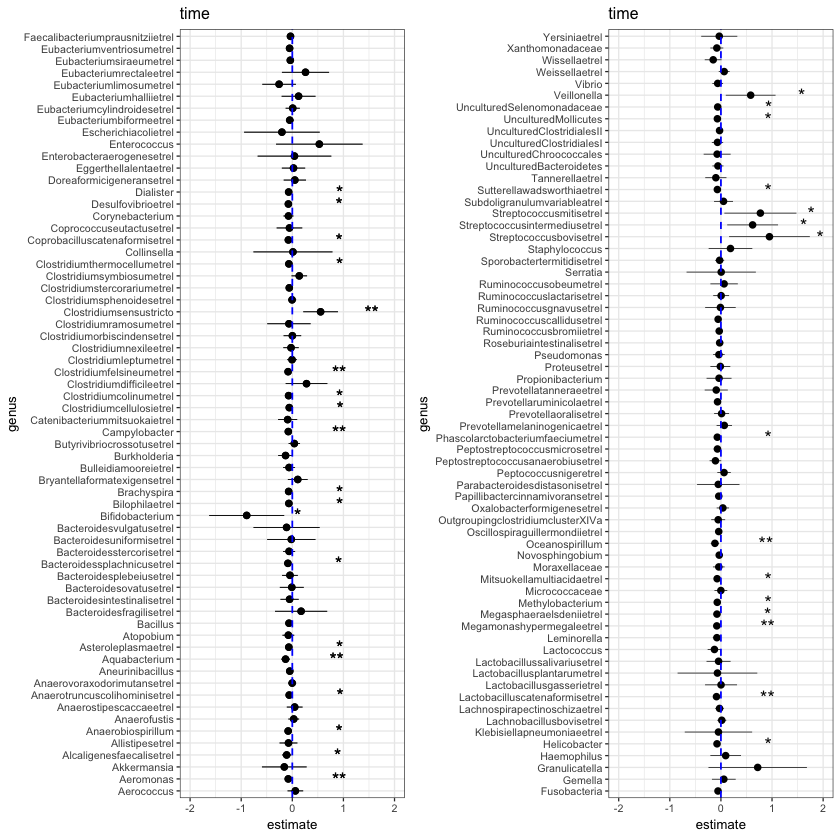

In [275]:
library(grid)

#grid.draw(cbind(ggplotGrob(lme4_plots[[1]][[1]]), ggplotGrob(lme4_plots[[1]][[2]]), size = "last"))
grid.draw(cbind(ggplotGrob(lme4_plots[[2]][[1]]), ggplotGrob(lme4_plots[[2]][[2]]), size = "last"))
#grid.draw(cbind(ggplotGrob(lme4_plots[[3]][[1]]), ggplotGrob(lme4_plots[[3]][[2]]), size = "last"))
#grid.draw(cbind(ggplotGrob(lme4_plots[[4]][[1]]), ggplotGrob(lme4_plots[[4]][[2]]), size = "last"))

In [245]:
lme4_final_table <-  lme4_final
colnames(lme4_final_table) <- str_to_title(colnames(lme4_final_table))
lme4_final_table %>%
    rename(P = P.value) %>%
    filter(P<=0.05, Q <= 0.2) %>%
    arrange(Parameter, desc(abs(Estimate))) %>%
    mutate_if(is.numeric, round, 2) %>%
    select(Parameter, Genus, everything()) 

Parameter     Genus                             Estimate Std.error Statistic
1  age           Streptococcusmitisetrel            0.48    0.18       2.62    
2  age           Streptococcusintermediusetrel      0.36    0.13       2.79    
3  age           Eubacteriumrectaleetrel            0.25    0.12       2.16    
4  age           Clostridiumsensustricto            0.23    0.09       2.59    
5  age           Gemella                            0.16    0.06       2.73    
6  age           Clostridiumsymbiosumetrel          0.09    0.04       2.55    
7  age           Vibrio                            -0.09    0.03      -2.93    
8  age           Aquabacterium                     -0.06    0.02      -2.74    
9  age           Sutterellawadsworthiaetrel        -0.04    0.02      -2.49    
10 age           Bacillus                          -0.04    0.02      -2.58    
11 age           Clostridiumstercorariumetrel      -0.04    0.02      -2.25    
12 age           Faecalibacteriumprausnitziietrel  -0.03    0.02      -2.08    
13 breastfeeding Staphylococcus                     0.21    0.07       3.12    
14 breastfeeding Ruminococcusobeumetrel            -0.11    0.04      -2.64    
15 breastfeeding Eggerthellalentaetrel             -0.10    0.04      -2.83    
16 breastfeeding Wissellaetrel                     -0.10    0.03      -3.76    
17 breastfeeding Bulleidiamooreietrel              -0.09    0.02      -4.91    
18 breastfeeding Vibrio                            -0.05    0.02      -3.02    
19 cc            Streptococcusintermediusetrel      0.49    0.20       2.44    
20 cc            Wissellaetrel                     -0.15    0.07      -2.16    
21 cc            Lactococcus                       -0.13    0.05      -2.42    
22 cc            Aquabacterium                     -0.11    0.03      -3.22    
23 cc            Alcaligenesfaecalisetrel          -0.10    0.04      -2.69    
24 cc            Bilophilaetrel                    -0.08    0.03      -2.93    
25 cc            Faecalibacteriumprausnitziietrel  -0.07    0.03      -2.89    
26 cc            Clostridiumstercorariumetrel      -0.07    0.03      -2.85    
27 cc            Bacillus                          -0.07    0.03      -2.65    
28 cc            Aneurinibacillus                  -0.07    0.02      -2.87    
29 cc            Coprobacilluscatenaformisetrel    -0.07    0.03      -2.48    
30 cc            Aeromonas                         -0.07    0.02      -2.79    
⋮  ⋮             ⋮                                 ⋮        ⋮         ⋮        
59 time          Veillonella                        0.58    0.24       2.39    
60 time          Clostridiumsensustricto            0.55    0.17       3.26    
61 time          Aquabacterium                     -0.13    0.04      -3.11    
62 time          Oceanospirillum                   -0.12    0.04      -2.88    
63 time          Alcaligenesfaecalisetrel          -0.11    0.05      -2.42    
64 time          Lactobacilluscatenaformisetrel    -0.09    0.03      -2.73    
65 time          Bacteroidessplachnicusetrel       -0.09    0.03      -2.51    
66 time          Clostridiumfelsineumetrel         -0.08    0.03      -2.72    
67 time          Anaerobiospirillum                -0.08    0.03      -2.56    
68 time          Megamonashypermegaleetrel         -0.08    0.03      -2.66    
69 time          Aeromonas                         -0.08    0.03      -2.63    
70 time          Campylobacter                     -0.08    0.03      -2.64    
71 time          Megasphaeraelsdeniietrel          -0.08    0.03      -2.25    
72 time          Coprobacilluscatenaformisetrel    -0.08    0.03      -2.26    
73 time          Desulfovibrioetrel                -0.08    0.03      -2.35    
74 time          Helicobacter                      -0.08    0.03      -2.57    
75 time          Mitsuokellamultiacidaetrel        -0.07    0.03      -2.34    
76 time          Clostridiumcolinumetrel           -0.07    0.03      -2.47    
77 

In [246]:
str_to_title(colnames(lme4_final_table))
    

[1] "Parameter" "Estimate"  "Std.error" "Statistic" "Df"        "P.value"  
[7] "Genus"     "Q"

### Alpha diversity

In [247]:
# fit models and pool estimates
lme4_fits_div <- 
    map(diversity_index, ~ data_imp_revc %>%
      future_map(lmer, formula = glue("{.x} ~ cc*time + age_d_s + bf_count_s + (1|subject_id)")) %>%
      pool() %>%
      summary() %>%
      rownames_to_column("parameter") %>%
      mutate(parameter = c("intercept", "cc", "time", "age", "breastfeeding", "cc_time")) %>%
      add_column(index = .x) 
    )

In [248]:
lme4_by_param_div <- lme4_fits_div %>% 
    map_df(bind_rows) %>%
    filter(parameter != "intercept") %>%
    group_by(parameter) %>%
    nest()

In [249]:
# calculate q value for each set of parameters, allow for 25% false discoveries
#lme4_by_param_div$data <- map(lme4_by_param_div$data, ~.x %>% mutate(q = qvalue(p.value)$qvalue))
lme4_final_div <- lme4_by_param_div %>% unnest()
lme4_final_div %>%
    arrange(parameter, desc(abs(estimate))) %>%
    mutate_if(is.numeric, round, 2) %>%
    select(parameter, index, everything())

parameter     index           estimate std.error statistic df     p.value
1  age           inverse_simpson  0.33    0.20       1.66     185.89 0.10   
2  age           shannon          0.10    0.06       1.52     185.88 0.13   
3  age           gini_simpson     0.04    0.02       1.86     185.98 0.06   
4  breastfeeding inverse_simpson -0.10    0.12      -0.82     146.01 0.41   
5  breastfeeding shannon         -0.06    0.04      -1.73     167.46 0.08   
6  breastfeeding gini_simpson    -0.01    0.01      -0.53     176.86 0.60   
7  cc            inverse_simpson  0.64    0.31       2.05     185.98 0.04   
8  cc            shannon          0.22    0.10       2.30     185.89 0.02   
9  cc            gini_simpson     0.08    0.03       2.23     186.01 0.03   
10 cc_time       inverse_simpson -0.80    0.32      -2.48     185.91 0.01   
11 cc_time       shannon         -0.25    0.09      -2.74     185.65 0.01   
12 cc_time       gini_simpson    -0.09    0.04      -2.40     185.98 0.02   
13 time          inverse_simpson  0.98    0.38       2.58     185.77 0.01   
14 time          shannon          0.28    0.12       2.38     185.79 0.02   
15 time          gini_simpson     0.11    0.04       2.52     185.96 0.01

In [250]:
data %>% 
    group_by(time, cc) %>% 
    summarise(
        shannon = glue("M = {round(mean(shannon), 2)}, SD = {round(sd(shannon), 2)}"),
        inverse_simpson = glue("M = {round(mean(inverse_simpson),2)}, SD = {round(sd(inverse_simpson), 2)}"),
        gini_simpson = glue("M = {round(mean(gini_simpson),2)}, SD = {round(sd(gini_simpson), 2)}")
    )

time cc  shannon             inverse_simpson     gini_simpson       
1 pre  no  M = 1.77, SD = 0.38 M = 2.84, SD = 1.37 M = 0.58, SD = 0.15
2 pre  yes M = 1.86, SD = 0.49 M = 3.19, SD = 1.45 M = 0.62, SD = 0.18
3 post no  M = 1.93, SD = 0.44 M = 3.21, SD = 1.65 M = 0.63, SD = 0.14
4 post yes M = 1.76, SD = 0.45 M = 2.77, SD = 1.25 M = 0.57, SD = 0.17

In [301]:
save.image(file = here("data/cc_analyses_workspace.RData"))